## Time Series LSTM
- Kaggle: [Corporación Favorita Grocery Sales Forecasting](https://www.kaggle.com/competitions/favorita-grocery-sales-forecasting)

## Preparation

In [1]:
from pyspark.sql import SparkSession
from tensorflow import keras
import tensorflow as tf
import plotly.io as pio

# Disable interactive visualization
# Requires kaleido and nbformat
pio.renderers.default = 'png'
pio.templates.default = 'plotly_dark'

# Set seed for possible reproducibility
# Affect Python, Numpy, and Keras
keras.utils.set_random_seed(1337)

# Initialize Spark (Pandas can't handle large dataset)
spark = SparkSession.builder \
        .master('local[*]') \
        .config('spark.dynamicAllocation.enabled', True) \
        .config('spark.dynamicAllocation.shuffleTracking.enabled', True) \
        .enableHiveSupport() \
        .getOrCreate()

print(spark.catalog.listDatabases())

# Check available GPU for TensorFlow
print(tf.config.list_physical_devices('GPU'))

[Database(name='default', catalog='spark_catalog', description='Default Hive database', locationUri='file:/C:/Users/Dhika/Documents/Projects/Proto/Python/TimeSeries/spark-warehouse')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Import Dataframe
- Pandas can't read data that is bigger than memory size (without chunking or limiting the rows), so PySpark can be used instead.

In [3]:
# Dataframe list
dfl = {
    'holidays_events': spark.read.csv('data/holidays_events.csv', header = True),
    'items': spark.read.csv('data/items.csv', header = True),
    'oil': spark.read.csv('data/oil.csv', header = True),
    'stores': spark.read.csv('data/stores.csv', header = True),
    'transactions': spark.read.csv('data/transactions.csv', header = True),
    # Test dataset doesn't have "unit_sales" so we can't compare the accuracy
    # As workaround we can just slice the already huge train dataset (4.65 GB)
    'sales': spark.read.csv('data/train.csv', header = True)
}

# for key in dfl:
#     dfl[key].createOrReplaceGlobalTempView(key)

In [4]:
from IPython.display import display_html
import pyspark.pandas as ps
import pandas as pd

def pandas_check(df):
    return type(df) == pd.DataFrame or type(df) == ps.DataFrame

# Display Pandas dataframe as grid
# https://stackoverflow.com/q/38783027 (modified)
def display_inline(dfs: list, titles: list = None, row_limit = 5):
    # Dataframes can be 2D nested list, but the title should not be nested
    # Only one title will be used for nested dataframes
    if titles == None: titles = [ f'' for i in dfs ]

    def _dataframe_check(df):
        if not pandas_check(df): df = df.limit(row_limit).toPandas()
        elif len(df) > row_limit: df = df.head(row_limit)
        return df

    output = '<span>'
    for (title, df) in zip(titles, dfs):
        length = len(df) if pandas_check(df) else df.count()

        output += '<div style="display: inline-block; border: 0.5px solid">'
        output += f'<div style="text-align: center">{title} (len: {length})</div>'

        if isinstance(df, list):
            for nested_df in df:
                nested_df = _dataframe_check(nested_df)
                output += nested_df.to_html(notebook = True)
        else:
            df = _dataframe_check(df)
            output += df.to_html(notebook = True)

        output += '</div>'
    output += '</span>'

    display_html(output, raw = True)

# Display scrollable dataframe (requires jinja2)
def display_scrollable(df: pd.DataFrame, row_limit = 500, height = 200):
    if not pandas_check(df): df = df.toPandas()
    if len(df) > row_limit: df = df.head(row_limit)

    display_html(
        f'<div style="height: {height}px; overflow: auto; width: fit-content">' +
        df.to_html(notebook = True) +
        '</div>',
        raw = True
    )

C:\Users\Dhika\Apps\CommonFiles\Spark\python\pyspark\pandas\__init__.py:50: UserWarning:

'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.



In [5]:
display_inline([ dfl[key] for key in dfl ], dfl)

holidays_events (len: 350) 

 
 
 
 
 date 
 type 
 locale 
 locale_name 
 description 
 transferred 
 
 
 
 
 0 
 2012-03-02 
 Holiday 
 Local 
 Manta 
 Fundacion de Manta 
 False 
 
 
 1 
 2012-04-01 
 Holiday 
 Regional 
 Cotopaxi 
 Provincializacion de Cotopaxi 
 False 
 
 
 2 
 2012-04-12 
 Holiday 
 Local 
 Cuenca 
 Fundacion de Cuenca 
 False 
 
 
 3 
 2012-04-14 
 Holiday 
 Local 
 Libertad 
 Cantonizacion de Libertad 
 False 
 
 
 4 
 2012-04-21 
 Holiday 
 Local 
 Riobamba 
 Cantonizacion de Riobamba 
 False 
 
 
 
 items (len: 4100) 

 
 
 
 
 item_nbr 
 family 
 class 
 perishable 
 
 
 
 
 0 
 96995 
 GROCERY I 
 1093 
 0 
 
 
 1 
 99197 
 GROCERY I 
 1067 
 0 
 
 
 2 
 103501 
 CLEANING 
 3008 
 0 
 
 
 3 
 103520 
 GROCERY I 
 1028 
 0 
 
 
 4 
 103665 
 BREAD/BAKERY 
 2712 
 1 
 
 
 
 oil (len: 1218) 

 
 
 
 
 date 
 dcoilwtico 
 
 
 
 
 0 
 2013-01-01 
 None 
 
 
 1 
 2013-01-02 
 93.14 
 
 
 2 
 2013-01-03 
 92.97 
 
 
 3 
 2013-01-04 
 93.12 
 
 
 4 
 2013-01-07 
 93.2 
 
 
 
 stores (len: 54) 

 
 
 
 
 store_nbr 
 city 
 state 
 type 
 cluster 
 
 
 
 
 0 
 1 
 Quito 
 Pichincha 
 D 
 13 
 
 
 1 
 2 
 Quito 
 Pichincha 
 D 
 13 
 
 
 2 
 3 
 Quito 
 Pichincha 
 D 
 8 
 
 
 3 
 4 
 Quito 
 Pichincha 
 D 
 9 
 
 
 4 
 5 
 Santo Domingo 
 Santo Domingo de los Tsachilas 
 D 
 4 
 
 
 
 transactions (len: 83488) 

 
 
 
 
 date 
 store_nbr 
 transactions 
 
 
 
 
 0 
 2013-01-01 
 25 
 770 
 
 
 1 
 2013-01-02 
 1 
 2111 
 
 
 2 
 2013-01-02 
 2 
 2358 
 
 
 3 
 2013-01-02 
 3 
 3487 
 
 
 4 
 2013-01-02 
 4 
 1922 
 
 
 
 sales (len: 125497040) 

 
 
 
 
 id 
 date 
 store_nbr 
 item_nbr 
 unit_sales 
 onpromotion 
 
 
 
 
 0 
 0 
 2013-01-01 
 25 
 103665 
 7.0 
 None 
 
 
 1 
 1 
 2013-01-01 
 25 
 105574 
 1.0 
 None 
 
 
 2 
 2 
 2013-01-01 
 25 
 105575 
 2.0 
 None 
 
 
 3 
 3 
 2013-01-01 
 25 
 108079 
 1.0 
 None 
 
 
 4 
 4 
 2013-01-01 
 25 
 108701 
 1.0 
 None

Field information:
- **onpromotion**: gives the total number of items in a product family that were being promoted at a store at a given date
- **sales**: gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips)
- **transferred**: holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday
- **dcoilwtico**: Daily oil price. Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices
- **cluster**: is a grouping of similar stores

Additional notes:
- Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this
- A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake
- Items marked as perishable have a score weight of 1.25; otherwise, the weight is 1.0
- Similar dataset: [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting)

## Data Preprocessing
- Please skip to the end of section (`skip_preproc = True`) if the preprocessed data has been saved (will save much time).

### Fix Data Types

In [6]:
# Check data types
for key in dfl:
    print(key, end = ' ')
    dfl[key].printSchema()

holidays_events root
 |-- date: string (nullable = true)
 |-- type: string (nullable = true)
 |-- locale: string (nullable = true)
 |-- locale_name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- transferred: string (nullable = true)

items root
 |-- item_nbr: string (nullable = true)
 |-- family: string (nullable = true)
 |-- class: string (nullable = true)
 |-- perishable: string (nullable = true)

oil root
 |-- date: string (nullable = true)
 |-- dcoilwtico: string (nullable = true)

stores root
 |-- store_nbr: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- type: string (nullable = true)
 |-- cluster: string (nullable = true)

transactions root
 |-- date: string (nullable = true)
 |-- store_nbr: string (nullable = true)
 |-- transactions: string (nullable = true)

sales root
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- store_nbr: string (nullable = true)
 |-- item_nbr: str

In [7]:
from pyspark.sql import functions as F
import pyspark.sql.types as types

for key in dfl:
    # Date
    if 'date' in dfl[key].columns:
        dfl[key] = dfl[key].withColumn('date', F.col('date').cast(types.DateType()))

    # Bool
    if 'transferred' in dfl[key].columns:
        dfl[key] = dfl[key].withColumn('transferred', F.col('transferred').cast(types.BooleanType()))
    if 'perishable' in dfl[key].columns:
        dfl[key] = dfl[key].withColumn('perishable', F.col('perishable').cast(types.BooleanType()))
    if 'onpromotion' in dfl[key].columns:
        dfl[key] = dfl[key].withColumn('onpromotion', F.col('onpromotion').cast(types.BooleanType()))

    # Int
    if 'class' in dfl[key].columns:
        dfl[key] = dfl[key].withColumn('class', F.col('class').cast(types.IntegerType()))
    if 'cluster' in dfl[key].columns:
        dfl[key] = dfl[key].withColumn('cluster', F.col('cluster').cast(types.IntegerType()))
    if 'item_nbr' in dfl[key].columns:
        dfl[key] = dfl[key].withColumn('item_nbr', F.col('item_nbr').cast(types.IntegerType()))
    if 'store_nbr' in dfl[key].columns:
        dfl[key] = dfl[key].withColumn('store_nbr', F.col('store_nbr').cast(types.IntegerType()))
    if 'transactions' in dfl[key].columns:
        dfl[key] = dfl[key].withColumn('transactions', F.col('transactions').cast(types.IntegerType()))

    # Float
    if 'unit_sales' in dfl[key].columns:
        dfl[key] = dfl[key].withColumn('unit_sales', F.col('unit_sales').cast(types.FloatType()))
    if 'dcoilwtico' in dfl[key].columns:
        dfl[key] = dfl[key].withColumn('dcoilwtico', F.col('dcoilwtico').cast(types.FloatType()))

In [8]:
# for key in dfl:
#     print(key, end = ' ')
#     dfl[key].printSchema()

### Fill Missing Values (1)
- PySpark may not detect/replace null values correctly if the data type is not numeric (e.g. int, float), so make sure to convert string or other unsupported type to numeric first. Empty string is not the same as null.
- The docs said that PySpark treat null and nan values differently, but it seems that `isNull` function still treat nan values as null. There are however separate function `F.isnull` and `F.isnan` that can be used too.

In [9]:
temp = []

# Check missing values
for key in dfl:
    temp.append(dfl[key].select(
        [ F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in dfl[key].columns ]
    ))

display_inline(temp, [i for i in dfl])
del temp

holidays_events (len: 1) 

 
 
 
 
 date 
 type 
 locale 
 locale_name 
 description 
 transferred 
 
 
 
 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 
 items (len: 1) 

 
 
 
 
 item_nbr 
 family 
 class 
 perishable 
 
 
 
 
 0 
 0 
 0 
 0 
 0 
 
 
 
 oil (len: 1) 

 
 
 
 
 date 
 dcoilwtico 
 
 
 
 
 0 
 0 
 43 
 
 
 
 stores (len: 1) 

 
 
 
 
 store_nbr 
 city 
 state 
 type 
 cluster 
 
 
 
 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 
 transactions (len: 1) 

 
 
 
 
 date 
 store_nbr 
 transactions 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 
 sales (len: 1) 

 
 
 
 
 id 
 date 
 store_nbr 
 item_nbr 
 unit_sales 
 onpromotion 
 
 
 
 
 0 
 0 
 0 
 0 
 0 
 0 
 21657651

Replace missing daily oil prices.
- Oil price on some dates are missing (will be filled after joining with sales)

In [10]:
from pyspark.sql import Window

dfl['oil'] = dfl['oil'].withColumn(
    'dcoilwtico',
    F.when(
        F.col('dcoilwtico').isNull(),
        # Fill current null value with the nearest non-null value
        # Checking from -1 (1 row before this) and all rows after this
        F.first_value('dcoilwtico', ignoreNulls = True).over(
            Window.orderBy('date').rowsBetween(-1, Window.unboundedFollowing)
        )
    # Otherwise is null by default
    ).otherwise(F.col('dcoilwtico'))
)

dfl['oil'].limit(5).toPandas()

date  dcoilwtico
0  2013-01-01   93.139999
1  2013-01-02   93.139999
2  2013-01-03   92.970001
3  2013-01-04   93.120003
4  2013-01-07   93.199997

Replace unknown product promotion.

In [11]:
# Assume as unknown product promotion as false (no promotion)
dfl['sales'] = dfl['sales'].fillna({'onpromotion': False})

dfl['sales'].limit(5).toPandas()

id        date  store_nbr  item_nbr  unit_sales  onpromotion
0  0  2013-01-01         25    103665         7.0        False
1  1  2013-01-01         25    105574         1.0        False
2  2  2013-01-01         25    105575         2.0        False
3  3  2013-01-01         25    108079         1.0        False
4  4  2013-01-01         25    108701         1.0        False

Check for missing sales/transactions.
- Transactions and sales are related, so we only need to check either one

In [12]:
import plotly.express as px

temp = dfl['transactions'].orderBy(['date', 'store_nbr']).toPandas()

fig = px.line(
    temp,
    x = 'date',
    y = 'transactions',
    color = 'store_nbr'
)

print(
    'This is an interactive graph, not all notebook viewer support it.',
    'If the graph doesn\'t show, run the code directly on your IDE.'
)

fig.show(renderer = 'vscode')
del temp

This is an interactive graph, not all notebook viewer support it. If the graph doesn't show, run the code directly on your IDE.


It seems that missing transactions/sales on some stores (e.g. store number 25) on certain dates is inevitable. It might be due to the store was not open yet, or the store was closed because of weekend or holiday. Filling missing data right now is not wise since we may need to do other data preprocessing tasks first.

### Remove Duplicates
- We only need to remove duplicates on `holidays_events` table

Remove transferred holiday since it's more like a normal day.

In [13]:
dfl['holidays_events'] = dfl['holidays_events'].where(
    F.col('transferred') == False
)

Give each holiday a unique id.
- Each holiday may affect sales differently (e.g. christmas, independence day), thus each of them need a unique id
- Since "locale_name" is not unique (see `Equador` for example), we can use "description" instead
- Earthquake on 16 April 2016 may also be considered "holiday" (special event that affect sales), but since it only happen once (not recurring) I decided not to add it

In [14]:
# For transferred holiday, we need to remove "Traslado" from the description
dfl['holidays_events'] = dfl['holidays_events'].withColumn(
    'description',
    # Traslado means transfer
    F.regexp_replace('description', 'Traslado ', '')
)

# Give unique id to each holiday (e.g. christmas will always have the same id)
# Holiday id will start from 1, so we can mark normal day as 0 later
dfl['holidays_events'] = dfl['holidays_events'].withColumn(
    'holiday_id',
    F.dense_rank().over(Window.orderBy('description'))
)

In [15]:
temp = dfl['holidays_events'].select(
    ['description', 'holiday_id']
).distinct().orderBy('holiday_id').toPandas()

# Save the holiday description to list
# To easily encode or decode between description or id
category_holidays = temp['description'].to_list()
category_holidays.insert(0, 'Normal Day')

display(temp)

description  holiday_id
0         Batalla de Pichincha           1
1                 Black Friday           2
2     Cantonizacion de Cayambe           3
3   Cantonizacion de El Carmen           4
4    Cantonizacion de Guaranda           5
..                         ...         ...
92          Terremoto Manabi+6          93
93          Terremoto Manabi+7          94
94          Terremoto Manabi+8          95
95          Terremoto Manabi+9          96
96               Viernes Santo          97

[97 rows x 2 columns]

Get days where there are more than 1 holiday events.

In [16]:
# "select" will return dataframe (even if there's only one column)
# If we manipulate column directly, we can't use most PySpark functions
date_duplicates = dfl['holidays_events'].select('date').exceptAll(
    dfl['holidays_events'].select('date').dropDuplicates()
).toPandas()['date'].to_list()

temp = dfl['holidays_events'].where(
    F.col('date').isin(date_duplicates)
).orderBy('date')

Prioritize the more significant holiday (local < regional < national) if there are more than 1 holiday events in a day.

In [17]:
# If ordered alphabetically, the order is local, national, then regional
# But we need the order to be national, regional, then local
# National holiday is more important than regional holiday, and so on
dfl['holidays_events'] = dfl['holidays_events'].withColumn(
    'locale',
    F.when(
        F.col('locale') == 'Local',
        F.lit('2_Local')
    ).when(
        F.col('locale') == 'Regional',
        F.lit('1_Regional')
    ).when(
        F.col('locale') == 'National',
        F.lit('0_National')
    )
)

# Sort "locale" so it's is always the same order (national, regional, then local)
# To only keep the first if there are more than 1 holiday events in a day
dfl['holidays_events'] = dfl['holidays_events'].orderBy(
    ['date', 'locale'],
    ascending = [True, True]
)

# Give number for each holiday in a day
# If there are 3 holidays in a day there will be 1, 2, 3
# On different day it will start from 1 again
dfl['holidays_events'] = dfl['holidays_events'].withColumn(
    'locale_num',
    F.row_number().over(
        Window.partitionBy('date').orderBy(['date', 'locale'])
    )
)

In [18]:
# Keep only the first (most important) holiday in each day
dfl['holidays_events'] = dfl['holidays_events'].where(F.col('locale_num') == 1)
dfl['holidays_events'] = dfl['holidays_events'].drop('locale_num')

In [19]:
print('Before duplicates removal:')
display(temp.limit(10).toPandas())

print('After duplicates removal:')
display(dfl['holidays_events'].where(
    F.col('date').isin(date_duplicates)
).limit(5).toPandas())

del date_duplicates
del temp

Before duplicates removal:


date        type    locale    locale_name  \
0  2012-06-25     Holiday     Local      Latacunga   
1  2012-06-25     Holiday     Local        Machala   
2  2012-06-25     Holiday  Regional       Imbabura   
3  2012-07-03     Holiday     Local      El Carmen   
4  2012-07-03     Holiday     Local  Santo Domingo   
5  2012-12-22     Holiday     Local        Salinas   
6  2012-12-22  Additional  National        Ecuador   
7  2012-12-24  Additional  National        Ecuador   
8  2012-12-24      Bridge  National        Ecuador   
9  2012-12-31  Additional  National        Ecuador   

                     description  transferred  holiday_id  
0     Cantonizacion de Latacunga        False           6  
1           Fundacion de Machala        False          25  
2  Provincializacion de Imbabura        False          56  
3     Cantonizacion de El Carmen        False           4  
4     Fundacion de Santo Domingo        False          30  
5       Cantonizacion de Salinas        False          10  
6                      Navidad-3        False          49  
7                      Navidad-1        False          47  
8                 Puente Navidad        False          59  
9           Primer dia del ano-1        False          53

After duplicates removal:


date        type      locale locale_name  \
0  2012-06-25     Holiday  1_Regional    Imbabura   
1  2012-07-03     Holiday     2_Local   El Carmen   
2  2012-12-22  Additional  0_National     Ecuador   
3  2012-12-24  Additional  0_National     Ecuador   
4  2012-12-31  Additional  0_National     Ecuador   

                     description  transferred  holiday_id  
0  Provincializacion de Imbabura        False          56  
1     Cantonizacion de El Carmen        False           4  
2                      Navidad-3        False          49  
3                      Navidad-1        False          47  
4           Primer dia del ano-1        False          53

### Data Transformation (1)
- Combine similar items based on item family (remove `item_nbr` and keep `family` instead)
- Transform family `unit_sales` as columns (instead of multiple rows) for each store

In [20]:
# Get family/category for each "item_nbr"
dfl['sales'] = dfl['sales'].alias('a').join(
    dfl['items'].alias('b'),
    'item_nbr',
    'left'
).select('a.*', 'b.family')

dfl['sales'].limit(5).toPandas()

item_nbr id        date  store_nbr  unit_sales  onpromotion        family
0    103665  0  2013-01-01         25         7.0        False  BREAD/BAKERY
1    105574  1  2013-01-01         25         1.0        False     GROCERY I
2    105575  2  2013-01-01         25         2.0        False     GROCERY I
3    108079  3  2013-01-01         25         1.0        False     GROCERY I
4    108701  4  2013-01-01         25         1.0        False          DELI

`join` or `groupby` operation (like above cell) will trigger partition shuffling. From now on, the data will be distributed across Spark partitions (in random order). Using `limit` or `show` to show the first N data can be a lot slower (can take 2-5 minutes) since the data may need to be searched first on each partition.

To workaround this, `coalesce` can be used to reduce the number of partitions to N, especially 1. This can be automated by setting `spark.sql.shuffle.partitions` when initializing Spark session. However, reducing partition to 1 may also affect parallelism (since only 1 node will be used?), so operation that iterate the whole dataframe (e.g. `count`) will also be a lot slower.

Based on my test, `limit` and `show` have similar performance, but people reported that `show` can be much faster on multi-cluster setup. I haven't found a nice workaround for this problem, so try not to check/show the dataframe too often.

In [21]:
dfl['sales'] = dfl['sales'].groupBy(['date', 'store_nbr', 'family']).agg(
    F.sum('unit_sales').alias('unit_sales'),
    # If most items in that family are on promotion, then mark it as true
    F.mode('onpromotion').alias('onpromotion')
)

In [22]:
# # Slow to calculate
# print('Total rows:', dfl['sales'].count())
# print('On promotion:', dfl['sales'].where(dfl['sales']['onpromotion'] == True).count())

Pivot columns so that `unit_sales` from each item family has their own column.
- Column that's not aggregated will be removed (i.e. `onpromotion`). It can be kept, but there will be too many columns
- Family name will be converted to numeric (`sales_0` = automotive, `sales_1` = baby care, etc)
- The `family` column itself will be lost after pivoting

In [23]:
# Make sales as separate columns rather than separate rows
# https://stackoverflow.com/questions/33732346
dfl['sales'] = dfl['sales'].groupBy(
    ['date', 'store_nbr']
).pivot('family').agg(*[
    F.first('unit_sales'),
    # F.first('onpromotion')
])

In [24]:
category_sales = []
i = 0

for col in dfl['sales'].columns[:]:
    if col not in ['date', 'store_nbr']:
        # Save original category columns
        category_sales.append(col)
        # Encode sales category columns (from categorical to numeric)
        dfl['sales'] = dfl['sales'].withColumnRenamed(col, f'sales_{i}')
        i += 1

print('Original column names:')
print(category_sales)

Original column names:
['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD']


In [25]:
dfl['sales'].limit(5).toPandas()

date  store_nbr  sales_0  sales_1  sales_2  sales_3  sales_4  \
0  2013-02-18         49      3.0      NaN      4.0   1875.0      NaN   
1  2013-03-31         31      7.0      NaN      1.0    781.0      NaN   
2  2013-01-23          2      2.0      NaN      1.0   1182.0      NaN   
3  2013-02-16         35      9.0      NaN      1.0    861.0      NaN   
4  2013-01-09         44     14.0      NaN      3.0   4112.0      NaN   

      sales_5  sales_6  sales_7  ...  sales_23    sales_24  sales_25  \
0  482.730000      NaN   1317.0  ...       NaN  476.553001     210.0   
1  416.000000      NaN   1076.0  ...       NaN  207.453000     301.0   
2  348.302999      NaN    719.0  ...       NaN  498.926005     155.0   
3  126.000000      NaN    531.0  ...       NaN  118.758000     116.0   
4  916.534000      NaN   2889.0  ...       NaN  926.779000     424.0   

   sales_26  sales_27    sales_28    sales_29  sales_30  sales_31   sales_32  
0       NaN       NaN  253.201003  231.067001       NaN       NaN  69.189999  
1       NaN       NaN   75.498000   28.000000       NaN       NaN   6.000000  
2       NaN       NaN  248.730002   82.707001       NaN       NaN  27.697000  
3       NaN       NaN   35.508000   16.000000       NaN       NaN   2.000000  
4       NaN       NaN  580.199002  499.402000       NaN       NaN  86.451000  

[5 rows x 35 columns]

Ideally, we should also do another transformation so **each date has only one row** (that contains all store sales and transactions). However, that will result more than 1000 columns, which for some reason will slow down the process when filling null values with nearest value at later steps (up to 1 hour and eventually run out of memory). We can do this later, or just skip it entirely.

**Edit:** After testing out, it seems that adding missing dates will actually worsen model training process, probably because I just filled the missing values with nearest/linear interpolation, which doesn't look like real data (e.g. doesn't contain sales spike on certain days).

### Join Related Tables

Join transactions with sales.

In [26]:
dfl['sales'] = dfl['sales'].alias('a').join(
    dfl['transactions'].alias('b'),
    ['date', 'store_nbr'],
    'left'
).select('a.*', 'b.transactions')

# dfl['sales'].limit(5).toPandas()

Join related store info with sales.
- City and cluster seems to be enough?
- City will need to be encoded as numeric values first

In [27]:
# Give each city a unique id first (categorical to numeric)
# Cluster is already numeric so no need to be converted
dfl['stores'] = dfl['stores'].withColumn(
    'city_id',
    F.dense_rank().over(Window.orderBy(
        # State and city may still be related
        # Cities on the same state should have adjacent numbers
        ['state', 'city']
    ))
)

# Save the list for easy encode/decode between city name and id
category_city = dfl['stores'].select(
    ['city', 'city_id']
).distinct().orderBy('city_id').toPandas()['city'].to_list()

# City id will start from 1, but list index start from 0
# To prevent inconsistency, we can add dummy value at the start of the list
category_city.insert(0, 'Unknown')

In [28]:
dfl['sales'] = dfl['sales'].alias('a').join(
    dfl['stores'].alias('b'),
    'store_nbr',
    'left'
).select(
    'a.*',
    F.col('b.city_id').alias('store_city'),
    F.col('b.cluster').alias('store_cluster')
)

In [29]:
dfl['sales'].limit(5).toPandas()

store_nbr        date  sales_0  sales_1  sales_2  sales_3  sales_4  \
0         49  2013-02-18      3.0      NaN      4.0   1875.0      NaN   
1         31  2013-03-31      7.0      NaN      1.0    781.0      NaN   
2          2  2013-01-23      2.0      NaN      1.0   1182.0      NaN   
3         35  2013-02-16      9.0      NaN      1.0    861.0      NaN   
4         44  2013-01-09     14.0      NaN      3.0   4112.0      NaN   

      sales_5  sales_6  sales_7  ...  sales_26  sales_27    sales_28  \
0  482.730000      NaN   1317.0  ...       NaN       NaN  253.201003   
1  416.000000      NaN   1076.0  ...       NaN       NaN   75.498000   
2  348.302999      NaN    719.0  ...       NaN       NaN  248.730002   
3  126.000000      NaN    531.0  ...       NaN       NaN   35.508000   
4  916.534000      NaN   2889.0  ...       NaN       NaN  580.199002   

     sales_29  sales_30  sales_31   sales_32  transactions  store_city  \
0  231.067001       NaN       NaN  69.189999          1760          19   
1   28.000000       NaN       NaN   6.000000          1256          13   
2   82.707001       NaN       NaN  27.697000          1951          19   
3   16.000000       NaN       NaN   2.000000           783          10   
4  499.402000       NaN       NaN  86.451000          4006          19   

   store_cluster  
0             11  
1             10  
2             13  
3              3  
4              5  

[5 rows x 38 columns]

Join oil prices with sales.

In [30]:
dfl['sales'] = dfl['sales'].alias('a').join(
    dfl['oil'].alias('b'),
    'date',
    'left'
).select('a.*', F.col('b.dcoilwtico').alias('oil_price'))

# dfl['sales'].limit(5).toPandas()

Join holidays with sales (and add other date/time related columns).
- There are different types of holiday (local, regional, and national)
- Each holiday may affect sales differently (e.g. christmas, independence day)
- Certain dates or days (e.g. weekends, start of month) may also affect sales, though not as significant as holiday

In [31]:
dfl['sales'] = dfl['sales'].alias('a').join(
    dfl['holidays_events'].alias('b'),
    'date',
    'left'
# Holiday id will start from 1
# We can use 0 as normal day (no holiday) later
).select('a.*', F.col('b.holiday_id'))

In [32]:
dfl['sales'] = dfl['sales'].withColumns({
    # 1 (January) - 12 (December)
    'year': F.year('date'),
    'month': F.month('date'),
    'day_of_month': F.dayofmonth('date'),
    # 1 (sunday) - 7 (saturday)
    'day_of_week': F.dayofweek('date')
})

# dfl['sales'].limit(5).toPandas()

In [33]:
display_scrollable(
    dfl['sales'].limit(5).toPandas()
)

date 
 store_nbr 
 sales_0 
 sales_1 
 sales_2 
 sales_3 
 sales_4 
 sales_5 
 sales_6 
 sales_7 
 sales_8 
 sales_9 
 sales_10 
 sales_11 
 sales_12 
 sales_13 
 sales_14 
 sales_15 
 sales_16 
 sales_17 
 sales_18 
 sales_19 
 sales_20 
 sales_21 
 sales_22 
 sales_23 
 sales_24 
 sales_25 
 sales_26 
 sales_27 
 sales_28 
 sales_29 
 sales_30 
 sales_31 
 sales_32 
 transactions 
 store_city 
 store_cluster 
 oil_price 
 holiday_id 
 year 
 month 
 day_of_month 
 day_of_week 
 
 
 
 
 0 
 2013-02-18 
 49 
 3.0 
 NaN 
 4.0 
 1875.0 
 NaN 
 482.730000 
 NaN 
 1317.0 
 808.0 
 219.844000 
 295.0 
 168.000 
 3836.0 
 54.0 
 1.0 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 3.0 
 NaN 
 90.0 
 NaN 
 476.553001 
 210.0 
 NaN 
 NaN 
 253.201003 
 231.067001 
 NaN 
 NaN 
 69.189999 
 1760 
 19 
 11 
 95.949997 
 NaN 
 2013 
 2 
 18 
 2 
 
 
 1 
 2013-03-31 
 31 
 7.0 
 NaN 
 1.0 
 781.0 
 NaN 
 416.000000 
 NaN 
 1076.0 
 279.0 
 194.326999 
 96.0 
 5.000 
 3007.0 
 16.0 
 2.0 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 2.0 
 3.0 
 NaN 
 NaN 
 207.453000 
 301.0 
 NaN 
 NaN 
 75.498000 
 28.000000 
 NaN 
 NaN 
 6.000000 
 1256 
 13 
 10 
 NaN 
 NaN 
 2013 
 3 
 31 
 1 
 
 
 2 
 2013-01-23 
 2 
 2.0 
 NaN 
 1.0 
 1182.0 
 NaN 
 348.302999 
 NaN 
 719.0 
 429.0 
 140.404000 
 135.0 
 105.434 
 2479.0 
 13.0 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 8.0 
 22.0 
 41.0 
 NaN 
 498.926005 
 155.0 
 NaN 
 NaN 
 248.730002 
 82.707001 
 NaN 
 NaN 
 27.697000 
 1951 
 19 
 13 
 95.059998 
 NaN 
 2013 
 1 
 23 
 4 
 
 
 3 
 2013-02-16 
 35 
 9.0 
 NaN 
 1.0 
 861.0 
 NaN 
 126.000000 
 NaN 
 531.0 
 65.0 
 83.000000 
 52.0 
 5.000 
 1513.0 
 3.0 
 1.0 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 118.758000 
 116.0 
 NaN 
 NaN 
 35.508000 
 16.000000 
 NaN 
 NaN 
 2.000000 
 783 
 10 
 3 
 NaN 
 NaN 
 2013 
 2 
 16 
 7 
 
 
 4 
 2013-01-09 
 44 
 14.0 
 NaN 
 3.0 
 4112.0 
 NaN 
 916.534000 
 NaN 
 2889.0 
 1548.0 
 462.916000 
 606.0 
 347.761 
 7546.0 
 121.0 
 1.0 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 2.0 
 11.0 
 199.0 
 NaN 
 926.779000 
 424.0 
 NaN 
 NaN 
 580.199002 
 499.402000 
 NaN 
 NaN 
 86.451000 
 4006 
 19 
 5 
 93.080002 
 NaN 
 2013 
 1 
 9 
 4

### Fill Missing Values (2)
- Note that this section will only fill null values, and does not add missing dates
- Adding missing dates doesn't guarantee better model, and can actually make it worse

Check if there's still missing value.

In [34]:
display_scrollable(
    dfl['sales'].select(
        [ F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in dfl['sales'].columns ]
    ).toPandas(),
    height = 50
)

date 
 store_nbr 
 sales_0 
 sales_1 
 sales_2 
 sales_3 
 sales_4 
 sales_5 
 sales_6 
 sales_7 
 sales_8 
 sales_9 
 sales_10 
 sales_11 
 sales_12 
 sales_13 
 sales_14 
 sales_15 
 sales_16 
 sales_17 
 sales_18 
 sales_19 
 sales_20 
 sales_21 
 sales_22 
 sales_23 
 sales_24 
 sales_25 
 sales_26 
 sales_27 
 sales_28 
 sales_29 
 sales_30 
 sales_31 
 sales_32 
 transactions 
 store_city 
 store_cluster 
 oil_price 
 holiday_id 
 year 
 month 
 day_of_month 
 day_of_week 
 
 
 
 
 0 
 0 
 0 
 4280 
 78269 
 16563 
 0 
 80834 
 0 
 32346 
 0 
 0 
 1 
 1 
 26 
 0 
 3685 
 36187 
 24169 
 24235 
 59486 
 29868 
 47086 
 35213 
 7249 
 8909 
 44079 
 1 
 1 
 42335 
 33479 
 14 
 20 
 18453 
 60036 
 10270 
 118 
 0 
 0 
 23907 
 71629 
 0 
 0 
 0 
 0

Fill missing holiday ids.

In [35]:
# 0 means normal day since holiday id starts from 1
dfl['sales'] = dfl['sales'].fillna({'holiday_id': 0})

Fill missing sales values.
- We can use either median (`percentile_approx`), mean (`avg`), `first_value`, `last_value`, `lead`, or `lag`
- Can be partitioned by `store_nbr` only, or also `year` and `month`, or no partition at all
- If using `store_nbr` only, all null values will be filled, even if the store didn't exist at that time yet

In [36]:
for col in dfl['sales'].columns:
    if 'sales_' in col:
        dfl['sales'] = dfl['sales'].withColumn(
            col,
            F.when(
                F.col(col).isNull(),
                # Fill current null value with the nearest non-null value
                # Checking from -1 (1 row before this) and all rows after this
                F.first_value(col, ignoreNulls = True).over(
                    Window.partitionBy(
                        ['store_nbr', 'year', 'month']
                    ).orderBy('date').rowsBetween(-1, Window.unboundedFollowing)
                )
            # When the value doesn't match "when", it will be replaced with null by default
            # So we need to create another condition that will keep the original value
            ).when(
                F.col(col).isNotNull(),
                F.col(col)
            )
        )

`withColumn` will iterate the rows to change the data. However, previously changed values using `withColumn` won't be known automatically on the next row iteration. This means that repeating null values at the end of rows won't be filled since changes using `rowsBetween(-1, Window.unboundedFollowing)` will only change the first null value (at the end of rows). The second null value (and the rest after that) will still see -1 (the previous) row as null.

To workaround this, we need to add another similar `withColumn` operation, but with different rules (see below). Luckily, only the `sales_*` column that has repeating nulls at the end, so we don't need to do this on other columns (e.g. `transactions`, `oil_price`).

In [37]:
for col in dfl['sales'].columns:
    if 'sales_' in col:
        dfl['sales'] = dfl['sales'].withColumn(
            col,
            F.when(
                F.col(col).isNull(),
                # Replace with last value instead of first
                F.last_value(col, ignoreNulls = True).over(
                    # Look back instead of look forward
                    Window.partitionBy(
                        ['store_nbr', 'year', 'month']
                    ).orderBy('date').rowsBetween(Window.unboundedPreceding, 1)
                )
            ).when(
                F.col(col).isNotNull(),
                F.col(col)
            )
        )

        # If the store is closed or don't sell a specific item family
        # Fill all null values with zeros instead
        dfl['sales'] = dfl['sales'].fillna({col: 0})

Fill missing transactions (same method as above).

In [38]:
for col in dfl['sales'].columns:
    if 'transactions' in col:
        dfl['sales'] = dfl['sales'].withColumn(
            col,
            F.when(
                F.col(col).isNull(),
                F.first_value(col, ignoreNulls = True).over(
                    Window.partitionBy(
                        ['store_nbr', 'year', 'month']
                    ).orderBy('date').rowsBetween(-1, Window.unboundedFollowing)
                )
            ).when(
                F.col(col).isNotNull(),
                F.col(col)
            )
        )

Fill missing oil price (again, same method as above).

In [39]:
dfl['sales'] = dfl['sales'].withColumn(
    'oil_price',
    F.when(
        F.col('oil_price').isNull(),
        F.first_value('oil_price', ignoreNulls = True).over(
            Window.orderBy('date').rowsBetween(-1, Window.unboundedFollowing)
        )
    ).when(
        F.col('oil_price').isNotNull(),
        F.col('oil_price')
    )
)

In [40]:
display_scrollable(
    dfl['sales'].limit(5).toPandas()
)

date 
 store_nbr 
 sales_0 
 sales_1 
 sales_2 
 sales_3 
 sales_4 
 sales_5 
 sales_6 
 sales_7 
 sales_8 
 sales_9 
 sales_10 
 sales_11 
 sales_12 
 sales_13 
 sales_14 
 sales_15 
 sales_16 
 sales_17 
 sales_18 
 sales_19 
 sales_20 
 sales_21 
 sales_22 
 sales_23 
 sales_24 
 sales_25 
 sales_26 
 sales_27 
 sales_28 
 sales_29 
 sales_30 
 sales_31 
 sales_32 
 transactions 
 store_city 
 store_cluster 
 oil_price 
 holiday_id 
 year 
 month 
 day_of_month 
 day_of_week 
 
 
 
 
 0 
 2013-01-02 
 1 
 2.0 
 0.0 
 2.0 
 1091.0 
 0.0 
 470.652000 
 0.0 
 1060.0 
 579.0 
 164.069000 
 246.0 
 131.000000 
 2652.0 
 31.0 
 3.0 
 0.0 
 0.0 
 2.0 
 0.0 
 0.0 
 10.0 
 13.0 
 67.0 
 0.0 
 369.101000 
 194.0 
 0.0 
 0.0 
 247.297004 
 47.0 
 0.0 
 0.0 
 38.028999 
 2111 
 19 
 13 
 93.139999 
 0 
 2013 
 1 
 2 
 4 
 
 
 1 
 2013-01-03 
 1 
 3.0 
 0.0 
 2.0 
 919.0 
 0.0 
 310.654999 
 0.0 
 836.0 
 453.0 
 151.581999 
 203.0 
 87.044001 
 2121.0 
 12.0 
 1.0 
 0.0 
 0.0 
 2.0 
 0.0 
 0.0 
 10.0 
 15.0 
 66.0 
 0.0 
 272.319002 
 153.0 
 0.0 
 0.0 
 187.277997 
 63.0 
 0.0 
 0.0 
 17.366000 
 1833 
 19 
 13 
 92.970001 
 0 
 2013 
 1 
 3 
 5 
 
 
 2 
 2013-01-04 
 1 
 3.0 
 0.0 
 3.0 
 953.0 
 0.0 
 198.366001 
 0.0 
 827.0 
 460.0 
 131.411000 
 171.0 
 65.000000 
 2056.0 
 15.0 
 7.0 
 0.0 
 0.0 
 2.0 
 0.0 
 0.0 
 7.0 
 24.0 
 102.0 
 0.0 
 454.171998 
 88.0 
 0.0 
 0.0 
 258.022999 
 67.0 
 0.0 
 0.0 
 29.907001 
 1863 
 19 
 13 
 93.120003 
 0 
 2013 
 1 
 4 
 6 
 
 
 3 
 2013-01-05 
 1 
 5.0 
 0.0 
 3.0 
 1160.0 
 0.0 
 301.056999 
 0.0 
 811.0 
 464.0 
 118.613000 
 177.0 
 70.000000 
 2216.0 
 30.0 
 1.0 
 0.0 
 0.0 
 2.0 
 0.0 
 0.0 
 10.0 
 20.0 
 159.0 
 0.0 
 328.939998 
 141.0 
 0.0 
 0.0 
 212.333005 
 66.0 
 0.0 
 0.0 
 24.842000 
 1509 
 19 
 13 
 93.199997 
 64 
 2013 
 1 
 5 
 7 
 
 
 4 
 2013-01-06 
 1 
 2.0 
 0.0 
 3.0 
 407.0 
 0.0 
 147.181999 
 0.0 
 257.0 
 212.0 
 60.135000 
 85.0 
 32.730000 
 723.0 
 5.0 
 2.0 
 0.0 
 0.0 
 2.0 
 0.0 
 0.0 
 10.0 
 20.0 
 159.0 
 0.0 
 113.282000 
 49.0 
 0.0 
 0.0 
 73.758000 
 25.0 
 0.0 
 0.0 
 5.000000 
 520 
 19 
 13 
 93.199997 
 0 
 2013 
 1 
 6 
 1

Recheck null values before exporting preprocessed data.
- If there are still null values, don't export yet and revise the previous cells

In [41]:
print("Number of null values on all rows")
display(
    dfl['sales'].select(
        [ F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in dfl['sales'].columns ]
    ).toPandas()
)

print("Row count for each store (null and non-null)")
display_scrollable(
    dfl['sales'].groupBy('store_nbr').count().orderBy('store_nbr').toPandas()
)

expr = [
    F.sum(
        F.when(
            F.col(c).isNull(),
            1
        ).otherwise(0)
    ).alias(c)
    for c in dfl['sales'].columns if c != 'store_nbr'
]

print('Number of null values on each store')
display_scrollable(
    dfl['sales'].groupBy('store_nbr').agg(*expr).orderBy('store_nbr').toPandas(),
    row_limit = 999
)

Number of null values on all rows


date  store_nbr  sales_0  sales_1  sales_2  sales_3  sales_4  sales_5  \
0     0          0        0        0        0        0        0        0   

   sales_6  sales_7  ...  sales_32  transactions  store_city  store_cluster  \
0        0        0  ...         0             0           0              0   

   oil_price  holiday_id  year  month  day_of_month  day_of_week  
0          0           0     0      0             0            0  

[1 rows x 44 columns]

Row count for each store (null and non-null)


store_nbr 
 count 
 
 
 
 
 0 
 1 
 1678 
 
 
 1 
 2 
 1679 
 
 
 2 
 3 
 1679 
 
 
 3 
 4 
 1679 
 
 
 4 
 5 
 1679 
 
 
 5 
 6 
 1679 
 
 
 6 
 7 
 1679 
 
 
 7 
 8 
 1679 
 
 
 8 
 9 
 1679 
 
 
 9 
 10 
 1679 
 
 
 10 
 11 
 1679 
 
 
 11 
 12 
 1619 
 
 
 12 
 13 
 1679 
 
 
 13 
 14 
 1641 
 
 
 14 
 15 
 1679 
 
 
 15 
 16 
 1679 
 
 
 16 
 17 
 1677 
 
 
 17 
 18 
 1569 
 
 
 18 
 19 
 1679 
 
 
 19 
 20 
 911 
 
 
 20 
 21 
 750 
 
 
 21 
 22 
 673 
 
 
 22 
 23 
 1679 
 
 
 23 
 24 
 1578 
 
 
 24 
 25 
 1618 
 
 
 25 
 26 
 1679 
 
 
 26 
 27 
 1679 
 
 
 27 
 28 
 1679 
 
 
 28 
 29 
 876 
 
 
 29 
 30 
 1656 
 
 
 30 
 31 
 1679 
 
 
 31 
 32 
 1679 
 
 
 32 
 33 
 1679 
 
 
 33 
 34 
 1679 
 
 
 34 
 35 
 1679 
 
 
 35 
 36 
 1553 
 
 
 36 
 37 
 1679 
 
 
 37 
 38 
 1679 
 
 
 38 
 39 
 1679 
 
 
 39 
 40 
 1679 
 
 
 40 
 41 
 1679 
 
 
 41 
 42 
 722 
 
 
 42 
 43 
 1675 
 
 
 43 
 44 
 1679 
 
 
 44 
 45 
 1679 
 
 
 45 
 46 
 1679 
 
 
 46 
 47 
 1679 
 
 
 47 
 48 
 1679 
 
 
 48 
 49 
 1679 
 
 
 49 
 50 
 1679 
 
 
 50 
 51 
 1679 
 
 
 51 
 52 
 118 
 
 
 52 
 53 
 1169 
 
 
 53 
 54 
 1679

Number of null values on each store


store_nbr 
 date 
 sales_0 
 sales_1 
 sales_2 
 sales_3 
 sales_4 
 sales_5 
 sales_6 
 sales_7 
 sales_8 
 sales_9 
 sales_10 
 sales_11 
 sales_12 
 sales_13 
 sales_14 
 sales_15 
 sales_16 
 sales_17 
 sales_18 
 sales_19 
 sales_20 
 sales_21 
 sales_22 
 sales_23 
 sales_24 
 sales_25 
 sales_26 
 sales_27 
 sales_28 
 sales_29 
 sales_30 
 sales_31 
 sales_32 
 transactions 
 store_city 
 store_cluster 
 oil_price 
 holiday_id 
 year 
 month 
 day_of_month 
 day_of_week 
 
 
 
 
 0 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 1 
 2 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 2 
 3 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 3 
 4 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 4 
 5 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 5 
 6 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 6 
 7 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 7 
 8 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 8 
 9 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 9 
 10 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 10 
 11 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 11 
 12 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 12 
 13 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 13 
 14 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 14 
 15 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 15 
 16 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 16 
 17 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 17 
 18 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 18 
 19 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 

Save the preprocessing result so we don't need to preprocess again.

In [5]:
skip_preproc = True

In [6]:
import json
import os

def dump_list(lst: list, file_path: str):
    # Convert list to dict, with list index as key
    lst_to_dict = { i: val for i, val in enumerate(lst) }
    # Save dict to file
    with open(file_path, 'w') as f:
        json.dump(lst_to_dict, f)

if not skip_preproc:
    dump_list(category_city, 'data/category_city.json')
    dump_list(category_sales, 'data/category_sales.json')
    dump_list(category_holidays, 'data/category_holidays.json')

    # Ensure the data is ordered before saving
    dfl['sales'] = dfl['sales'].orderBy('date')

    # Without "coalesce(1)", the data will be split in multiple files
    dfl['sales'].coalesce(1).write.csv(
        'file:///' + os.path.abspath('data/sales.csv'),
        header = True,
        mode = 'overwrite'
    )

In [7]:
from pyspark.sql import functions as F
import pyspark.sql.types as types

def load_list(file_path: str):
    with open(file_path, 'r') as f:
        temp = json.load(f)
        # Assume the dict keys are ordered correctly
        return [ i for i in temp.values() ]

if skip_preproc:
    dfl['sales'] = spark.read.csv(
        'data/sales.csv/part-00000-27ccd002-8854-472f-a77f-3ebee708f85d-c000.csv',
        header = True
    )

    for col in dfl['sales'].columns:
        if 'sales_' in col or 'oil_price' in col:
            dfl['sales'] = dfl['sales'].withColumn(col, F.col(col).cast(types.FloatType()))
        elif 'date' in col:
            dfl['sales'] = dfl['sales'].withColumn(col, F.col(col).cast(types.DateType()))
        else:
            dfl['sales'] = dfl['sales'].withColumn(col, F.col(col).cast(types.IntegerType()))

    category_city = load_list('data/category_city.json')
    category_sales = load_list('data/category_sales.json')
    category_holidays = load_list('data/category_holidays.json')

### Simple EDA
This EDA is just a generalization, in fact each store may have its own unique sales and transaction pattern.

In [8]:
print('Product category:', dfl['items'].select('family').distinct().count())
print('Store:', dfl['stores'].select('store_nbr').distinct().count())
print('Holidays:', dfl['holidays_events'].select('locale_name').distinct().count())

Product category: 33
Store: 54
Holidays: 24


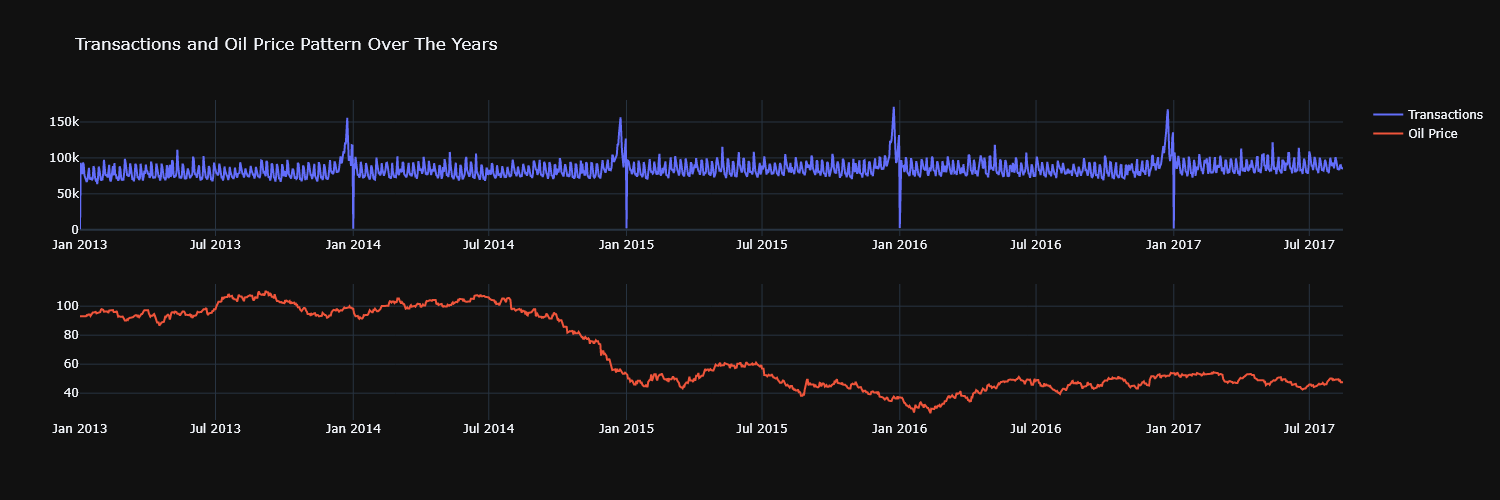

In [9]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

temp = dfl['sales'].groupBy('date').agg(
    F.sum('transactions').alias('transactions'),
    F.first('oil_price').alias('oil_price')
).orderBy('date').toPandas()

fig = make_subplots(2, 1)

fig.add_trace(
    go.Scatter(x = temp['date'], y = temp['transactions'], name = 'Transactions'),
    1, 1
)

fig.add_trace(
    go.Scatter(x = temp['date'], y = temp['oil_price'], name = 'Oil Price'),
    2, 1
)

fig.update_layout(title = 'Transactions and Oil Price Pattern Over The Years')
fig.show(width = 1500)

The oil price pattern is unpredictable, but we still can see the same yearly pattern from the transactions graph above.

## Model Preprocessing and Training
Some codes are modified/inspired from these main references:
- [GCN LSTM Time Series](https://stellargraph.readthedocs.io/en/stable/demos/time-series/gcn-lstm-time-series.html) (StellarGraph)
- [Multivariate Multi-Step Time Series Forecasting](https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/) (Analytics Vidhya)
- [Multivariate Time Series Forecasting LSTMs Keras](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/) (Machine Learning Mastery)
- [Store Sales Forecasting](https://www.kaggle.com/code/karan842/store-sales-forecasting-eda-lstm/) (Kaggle)
- [Multiple Stock Prediction](https://www.kaggle.com/code/humamfauzi/multiple-stock-prediction-using-single-nn/) (Kaggle)

### Data Transformation (2)

Pivot sales columns so that each date is only represented by 1 row (containing all store sales and transactions).
- This may be important since there is usually only 1 row per time step (date) when using LSTM to predict time series data
- Sales will be labeled `X_sales_Y`, where X is `store_nbr` and Y is `family` (there will be 1000+ columns)
- The `store_nbr` column itself will be lost after pivoting

**Note:** Disabled for now, too complex to train (without GPU), and can't be adapted for new store(s) without remaking the whole model. I'm using multiple model `fit` as alternative ([reference](https://www.kaggle.com/code/humamfauzi/multiple-stock-prediction-using-single-nn/)). This will group data by store number and re-train the model on each loop.

In [68]:
# misc_cols = ['oil_price', 'holiday_id', 'year', 'month', 'day_of_month', 'day_of_week']

# # Separate some columns before pivot operation
# # To be joined again after pivoting
# temp = dfl['sales'].groupBy('date').agg(*[
#     F.first(c).alias(c) for c in dfl['sales'].columns
#     if c in misc_cols
# ])

In [69]:
# # Make sales as separate columns rather than separate rows
# # https://stackoverflow.com/questions/33732346
# dfl['sales'] = dfl['sales'].groupBy(
#     'date'
# ).pivot('store_nbr').agg(
#     # There is no duplicate store per date, so "first" can be used
#     *[
#         F.first(c).alias(c) for c in dfl['sales'].columns
#         if 'sales_' in c or c in ['transactions', 'store_city', 'store_cluster']
#     ]
# )

# dfl['sales'] = dfl['sales'].alias('a').join(
#     temp.alias('b'),
#     'date',
#     'left'
# ).select(
#     'a.*',
#     *[ F.col(f'b.{c}').alias(c) for c in misc_cols ]
# )

# del misc_cols
# del temp

In [186]:
display_scrollable(
    dfl['sales'].limit(5).toPandas()
)

date 
 store_nbr 
 sales_0 
 sales_1 
 sales_2 
 sales_3 
 sales_4 
 sales_5 
 sales_6 
 sales_7 
 sales_8 
 sales_9 
 sales_10 
 sales_11 
 sales_12 
 sales_13 
 sales_14 
 sales_15 
 sales_16 
 sales_17 
 sales_18 
 sales_19 
 sales_20 
 sales_21 
 sales_22 
 sales_23 
 sales_24 
 sales_25 
 sales_26 
 sales_27 
 sales_28 
 sales_29 
 sales_30 
 sales_31 
 sales_32 
 transactions 
 store_city 
 store_cluster 
 oil_price 
 holiday_id 
 year 
 month 
 day_of_month 
 day_of_week 
 
 
 
 
 0 
 2013-01-01 
 25 
 1.0 
 0.0 
 2.0 
 810.0 
 0.0 
 180.589005 
 0.0 
 186.0 
 143.0 
 71.089996 
 46.0 
 29.654999 
 700.0 
 15.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 2.0 
 5.0 
 105.0 
 0.0 
 110.801003 
 25.0 
 0.0 
 0.0 
 42.637001 
 37.847000 
 0.0 
 0.0 
 4.000000 
 770 
 20 
 1 
 93.139999 
 52 
 2013 
 1 
 1 
 3 
 
 
 1 
 2013-01-02 
 1 
 2.0 
 0.0 
 2.0 
 1091.0 
 0.0 
 470.652008 
 0.0 
 1060.0 
 579.0 
 164.069000 
 246.0 
 131.000000 
 2652.0 
 31.0 
 3.0 
 0.0 
 0.0 
 2.0 
 0.0 
 0.0 
 10.0 
 13.0 
 67.0 
 0.0 
 369.101013 
 194.0 
 0.0 
 0.0 
 247.296997 
 47.000000 
 0.0 
 0.0 
 38.028999 
 2111 
 19 
 13 
 93.139999 
 0 
 2013 
 1 
 2 
 4 
 
 
 2 
 2013-01-02 
 2 
 8.0 
 0.0 
 3.0 
 1481.0 
 0.0 
 523.882019 
 0.0 
 1432.0 
 651.0 
 303.875000 
 307.0 
 111.099998 
 3870.0 
 39.0 
 1.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 2.0 
 16.0 
 29.0 
 0.0 
 655.625977 
 333.0 
 0.0 
 0.0 
 342.505981 
 127.357002 
 0.0 
 0.0 
 31.373001 
 2358 
 19 
 13 
 93.139999 
 0 
 2013 
 1 
 2 
 4 
 
 
 3 
 2013-01-02 
 3 
 10.0 
 0.0 
 15.0 
 4486.0 
 0.0 
 1361.635986 
 0.0 
 3101.0 
 1606.0 
 600.273010 
 814.0 
 490.390991 
 8463.0 
 93.0 
 3.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 10.0 
 38.0 
 122.0 
 0.0 
 945.635986 
 623.0 
 0.0 
 0.0 
 681.348022 
 428.000000 
 0.0 
 0.0 
 169.063995 
 3487 
 19 
 8 
 93.139999 
 0 
 2013 
 1 
 2 
 4 
 
 
 4 
 2013-01-02 
 4 
 12.0 
 0.0 
 7.0 
 1545.0 
 0.0 
 422.536987 
 0.0 
 1358.0 
 589.0 
 268.343994 
 273.0 
 146.132004 
 4087.0 
 43.0 
 1.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 9.0 
 11.0 
 27.0 
 0.0 
 494.204010 
 387.0 
 0.0 
 0.0 
 385.806976 
 109.061996 
 0.0 
 0.0 
 25.997999 
 1922 
 19 
 9 
 93.139999 
 0 
 2013 
 1 
 2 
 4

We will use Pandas (`pd.DataFrame`) from now on instead of PySpark (for compatibility with other libraries). Although there's also Pandas on Spark API (`ps.DataFrame`), it is usually based on older Pandas version and can cause error when passed to `sklearn` or `tensorflow` functions.

In [10]:
dfpd = dfl['sales'].orderBy('date').toPandas()
print(type(dfpd))

<class 'pandas.core.frame.DataFrame'>


### Fill Missing Values (3)
- Optional, may worsen model training process since the data is no longer natural (**edit:** after testing out, it's true)
- Add missing dates for each store that I forgot to do before
- Fill missing values after adding dates 

In [11]:
fill_missing_dates = False

# After adding missing dates, stores can't no longer be sorted by age
# Save it in case we need it later (e.g. for training model)
store_from_oldest = dfpd.sort_values('date')['store_nbr'].unique()

In [12]:
if fill_missing_dates:
    print('Number of rows before adding dates:', len(dfpd))

    # Add missing dates for each store (nan values must be filled, or there will be skipped rows)
    # https://stackoverflow.com/questions/44978196/pandas-filling-missing-dates-and-values-within-group
    dfpd = dfpd.set_index(['date', 'store_nbr']).unstack(fill_value = -999).asfreq('D', fill_value = -999).stack().sort_index(level = 1)
    dfpd = dfpd.sort_values(['date', 'store_nbr']).reset_index()

    print('Number of rows after adding dates:', len(dfpd))
    display_scrollable(dfpd)

In [13]:
import numpy as np
import re

# Will be used again in later steps
def matched_columns(all_cols: list, wanted_cols: list):
    '''Returns regex matched columns while keeping the order like `wanted_cols`'''
    filtered_cols = []

    for i in wanted_cols:
        for j in all_cols:
            # Exact match only (won't match on the middle of string)
            if re.search('^' + i + '$', j): filtered_cols.append(j)

    return filtered_cols

if fill_missing_dates:
    # Fill missing sales and transactions
    # NOTE: Backfill interpolation may be innacurate
    cols = matched_columns(dfpd.columns, [r'sales_[\w]*', 'transactions'])
    for c in cols:
        dfpd[c] = dfpd[c].replace(-999, np.nan)
        dfpd[c] = dfpd.groupby('store_nbr')[c].apply(
            lambda x: x.interpolate(limit_direction = 'both')
        ).reset_index(drop = True)

    # Fill missing daily related data
    cols = ['oil_price', 'holiday_id', 'year', 'month', 'day_of_month', 'day_of_week']
    for c in cols:
        dfpd[c] = dfpd[c].replace(-999, np.nan)
        dfpd[c] = dfpd.groupby('date')[c].transform(
            lambda x: x.ffill().bfill()
        ).reset_index(drop = True)

    # Fill missing store related data
    cols = ['store_city', 'store_cluster']
    for c in cols:
        dfpd[c] = dfpd[c].replace(-999, np.nan)
        dfpd[c] = dfpd.groupby('store_nbr')[c].transform(
            lambda x: x.ffill().bfill()
        ).reset_index(drop = True)

    # If there are still missing values (probably not), fill with zero
    dfpd = dfpd.fillna(0)

In [14]:
if fill_missing_dates:
    cols = matched_columns(dfpd.columns, [r'sales_[\w]*', 'transactions', 'oil_price'])
    for c in cols: dfpd[c] = dfpd[c].astype(np.float32)

    cols = [
        'store_nbr', 'store_city', 'store_cluster',
        'holiday_id', 'year', 'month', 'day_of_month', 'day_of_week'
    ]
    for c in cols: dfpd[c] = dfpd[c].astype(np.int32)

In [15]:
if fill_missing_dates:
    dfpd = dfpd.sort_values(['date', 'store_nbr']).reset_index(drop = True)
    dfpd.head()

### One Hot Encode
**Note:** Shouldn't be used if the previous data transformation is enabled (there will be 2000+ columns).

When using LSTM, usually categorical values that has no natural ordering (e.g. city, cluster) should be encoded as one hot vector (multiple columns) since the model may not be sensitive enough if we keep all the values in one column. In this case, the columns that can be transformed are `store_nbr`, `store_city`, `store_cluster`.

As for `holiday_id`, I think it's fine to keep it as one column since it still has natural order (e.g. Christmas will always be on 25 December). However, this may need to be changed if `holiday_id` is the target prediction (not an input feature).

[Reference 1](https://datascience.stackexchange.com/questions/45803/should-we-use-only-one-hot-vector-for-lstm-input-outputs), [reference 2](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/), [code example](https://www.kaggle.com/code/kaggleslayer/grocery-prediction-with-neural-network).

In [16]:
# import pyspark.pandas as pd
import pandas as pd

# "get_dummies" will remove the original (untransformed) column
# However, store number may still be needed for grouping later
store_orig = dfpd['store_nbr']

# One hot encodes columns
dfpd = pd.get_dummies(
    dfpd,
    columns = ['store_nbr', 'store_city', 'store_cluster']
)

# Join store number again
dfpd = pd.concat([dfpd, store_orig], axis = 1)
del store_orig

display_scrollable(dfpd.head())

date 
 sales_0 
 sales_1 
 sales_2 
 sales_3 
 sales_4 
 sales_5 
 sales_6 
 sales_7 
 sales_8 
 sales_9 
 sales_10 
 sales_11 
 sales_12 
 sales_13 
 sales_14 
 sales_15 
 sales_16 
 sales_17 
 sales_18 
 sales_19 
 sales_20 
 sales_21 
 sales_22 
 sales_23 
 sales_24 
 sales_25 
 sales_26 
 sales_27 
 sales_28 
 sales_29 
 sales_30 
 sales_31 
 sales_32 
 transactions 
 oil_price 
 holiday_id 
 year 
 month 
 day_of_month 
 day_of_week 
 store_nbr_1 
 store_nbr_2 
 store_nbr_3 
 store_nbr_4 
 store_nbr_5 
 store_nbr_6 
 store_nbr_7 
 store_nbr_8 
 store_nbr_9 
 store_nbr_10 
 store_nbr_11 
 store_nbr_12 
 store_nbr_13 
 store_nbr_14 
 store_nbr_15 
 store_nbr_16 
 store_nbr_17 
 store_nbr_18 
 store_nbr_19 
 store_nbr_20 
 store_nbr_21 
 store_nbr_22 
 store_nbr_23 
 store_nbr_24 
 store_nbr_25 
 store_nbr_26 
 store_nbr_27 
 store_nbr_28 
 store_nbr_29 
 store_nbr_30 
 store_nbr_31 
 store_nbr_32 
 store_nbr_33 
 store_nbr_34 
 store_nbr_35 
 store_nbr_36 
 store_nbr_37 
 store_nbr_38 
 store_nbr_39 
 store_nbr_40 
 store_nbr_41 
 store_nbr_42 
 store_nbr_43 
 store_nbr_44 
 store_nbr_45 
 store_nbr_46 
 store_nbr_47 
 store_nbr_48 
 store_nbr_49 
 store_nbr_50 
 store_nbr_51 
 store_nbr_52 
 store_nbr_53 
 store_nbr_54 
 store_city_1 
 store_city_2 
 store_city_3 
 store_city_4 
 store_city_5 
 store_city_6 
 store_city_7 
 store_city_8 
 store_city_9 
 store_city_10 
 store_city_11 
 store_city_12 
 store_city_13 
 store_city_14 
 store_city_15 
 store_city_16 
 store_city_17 
 store_city_18 
 store_city_19 
 store_city_20 
 store_city_21 
 store_city_22 
 store_cluster_1 
 store_cluster_2 
 store_cluster_3 
 store_cluster_4 
 store_cluster_5 
 store_cluster_6 
 store_cluster_7 
 store_cluster_8 
 store_cluster_9 
 store_cluster_10 
 store_cluster_11 
 store_cluster_12 
 store_cluster_13 
 store_cluster_14 
 store_cluster_15 
 store_cluster_16 
 store_cluster_17 
 store_nbr 
 
 
 
 
 0 
 2013-01-01 
 1.0 
 0.0 
 2.0 
 810.0 
 0.0 
 180.589005 
 0.0 
 186.0 
 143.0 
 71.089996 
 46.0 
 29.654999 
 700.0 
 15.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 2.0 
 5.0 
 105.0 
 0.0 
 110.801003 
 25.0 
 0.0 
 0.0 
 42.637001 
 37.847000 
 0.0 
 0.0 
 4.000000 
 770 
 93.139999 
 52 
 2013 
 1 
 1 
 3 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 True 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 True 
 False 
 False 
 True 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 25 
 
 
 1 
 2013-01-02 
 2.0 
 0.0 
 2.0 
 1091.0 
 0.0 
 470.652008 
 0.0 
 1060.0 
 579.0 
 164.069000 
 246.0 
 131.000000 
 2652.0 
 31.0 
 3.0 
 0.0 
 0.0 
 2.0 
 0.0 
 0.0 
 10.0 
 13.0 
 67.0 
 0.0 
 369.101013 
 194.0 
 0.0 
 0.0 
 247.296997 
 47.000000 
 0.0 
 0.0 
 38.028999 
 2111 
 93.139999 
 0 
 2013 
 1 
 2 
 4 
 True 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 True 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 
 False 

### Train-Test Split

Get total rows and dates.

In [17]:
print('Total rows:', len(dfpd))

# Any column will do, we just need to look at the date and index
temp = dfpd.groupby('date', as_index = False)['store_nbr'].count().sort_values('date')
print('Total days:', len(temp))

temp

Total rows: 83606
Total days: 1684


date  store_nbr
0     2013-01-01          1
1     2013-01-02         46
2     2013-01-03         46
3     2013-01-04         46
4     2013-01-05         46
...          ...        ...
1679  2017-08-11         54
1680  2017-08-12         54
1681  2017-08-13         54
1682  2017-08-14         54
1683  2017-08-15         54

[1684 rows x 2 columns]

80% of 1684 is 1347 days, leaving 337 days (20%) for test. Index start from 0, so train data will be from index 0-1346.

In [18]:
# Check first date of test data
temp.iloc[[1347]]

date  store_nbr
1347  2016-09-12         51

In [19]:
import numpy as np

def train_test_split(df: pd.DataFrame, train_portion: float = 0.8, echo: bool = True):
    # Get num of days in data
    date_rows = df['date'].sort_values().unique()
    time_len = date_rows.shape[0]

    # Get first date of test data
    train_size = int(time_len * train_portion)
    test_first_date = date_rows[train_size]

    # Split train and test data based on last date
    train_data = df.loc[ df['date'] < test_first_date ].sort_values('date')
    test_data = df.loc[ df['date'] >= test_first_date ].sort_values('date')

    if echo:
        print('Total days:', time_len, f'({len(df)} rows)')
        print('Days for train:', train_size, f'({len(train_data)} rows)')
        print('Days for test:', time_len - train_size, f'({len(test_data)} rows)')

    return train_data, test_data

train_data, test_data = train_test_split(dfpd)

Total days: 1684 (83606 rows)
Days for train: 1347 (65810 rows)
Days for test: 337 (17796 rows)


### Min-Max Scaler

Depending on your data characteristics (number of features, date as row/column?), you may want use different scaling technique, e.g. for whole data (global min-max) or per row/column (local min-max) ([reference](https://stellargraph.readthedocs.io/en/stable/demos/time-series/gcn-lstm-time-series.html)). `MinMaxScaler` is a column based (local) scaler.

**Note:** In case Pandas warning appeared, just ignore it, don't use `loc` or `iloc` to assign data since it will replace the original data. Please always use a `copy`.

In [20]:
from sklearn.preprocessing import MinMaxScaler

def columns_except(df: pd.DataFrame, col_exceptions: list):
    '''Returns all columns except some (exact match only, no regex)'''
    return [ c for c in df.columns if c not in col_exceptions ]

# Save the variable for inverse transform later
# NOTE: Another scaler may also be needed after separating X and Y
scaler = MinMaxScaler()

def scaler_transform(df: pd.DataFrame, col_exceptions: list, fit: bool):
    '''Transform some/all columns of dataframe'''
    df = df.copy()
    df_col = columns_except(df, col_exceptions)

    # Train data must be fitted, test data can use fitted values from train data
    # Fit will save min and max values for each column, and use it to transform data
    if fit: df[df_col] = scaler.fit_transform(df[df_col])
    else: df[df_col] = scaler.transform(df[df_col])

    return df

def scaler_inv_transform(df: pd.DataFrame, col_exceptions: list):
    '''Inverse transform some/all columns of dataframe'''
    df = df.copy()
    df_col = columns_except(df, col_exceptions)
    df[df_col] = scaler.inverse_transform(df[df_col])
    return df

train_data = scaler_transform(train_data, ['date', 'store_nbr'], fit = True)
test_data = scaler_transform(test_data, ['date', 'store_nbr'], fit = False)

In [21]:
# Check whether the dates are splitted correctly or not
display(train_data.tail(1))
display(test_data.head(1))

date   sales_0  sales_1   sales_2   sales_3  sales_4   sales_5  \
65809  2016-09-11  0.069498      0.0  0.014599  0.386423      0.0  0.087764   

        sales_6   sales_7   sales_8  ...  store_cluster_9  store_cluster_10  \
65809  0.007848  0.341878  0.166106  ...              0.0               0.0   

       store_cluster_11  store_cluster_12  store_cluster_13  store_cluster_14  \
65809               0.0               0.0               0.0               0.0   

       store_cluster_15  store_cluster_16  store_cluster_17  store_nbr  
65809               0.0               0.0               0.0         54  

[1 rows x 135 columns]

date   sales_0  sales_1   sales_2   sales_3  sales_4   sales_5  \
65810  2016-09-12  0.030888      0.0  0.051095  0.390221      0.0  0.102682   

        sales_6   sales_7   sales_8  ...  store_cluster_9  store_cluster_10  \
65810  0.005605  0.269939  0.231627  ...              0.0               0.0   

       store_cluster_11  store_cluster_12  store_cluster_13  store_cluster_14  \
65810               0.0               0.0               1.0               0.0   

       store_cluster_15  store_cluster_16  store_cluster_17  store_nbr  
65810               0.0               0.0               0.0          1  

[1 rows x 135 columns]

### Split Features (X) and Targets/Labels (Y)

In [23]:
x_col = [
    # Will drop date and the original (non-encoded) store number
    'year', 'month', 'day_of_month', 'day_of_week',
    r'sales_[\w]*', 'transactions',
    r'store_nbr_[\w]*', r'store_city_[\w]*', r'store_cluster_[\w]*',
    'holiday_id', 'oil_price'
]

y_col = [
    # No need to predict year, month, holiday id, etc
    # Store number isn't needed too since fit/predict should be separated per store
    r'sales_[\w]*', 'transactions'
]

x_col = matched_columns(dfpd.columns, x_col)
y_col = matched_columns(dfpd.columns, y_col)

print(x_col)
print(y_col)

['year', 'month', 'day_of_month', 'day_of_week', 'sales_0', 'sales_1', 'sales_2', 'sales_3', 'sales_4', 'sales_5', 'sales_6', 'sales_7', 'sales_8', 'sales_9', 'sales_10', 'sales_11', 'sales_12', 'sales_13', 'sales_14', 'sales_15', 'sales_16', 'sales_17', 'sales_18', 'sales_19', 'sales_20', 'sales_21', 'sales_22', 'sales_23', 'sales_24', 'sales_25', 'sales_26', 'sales_27', 'sales_28', 'sales_29', 'sales_30', 'sales_31', 'sales_32', 'transactions', 'store_nbr_1', 'store_nbr_2', 'store_nbr_3', 'store_nbr_4', 'store_nbr_5', 'store_nbr_6', 'store_nbr_7', 'store_nbr_8', 'store_nbr_9', 'store_nbr_10', 'store_nbr_11', 'store_nbr_12', 'store_nbr_13', 'store_nbr_14', 'store_nbr_15', 'store_nbr_16', 'store_nbr_17', 'store_nbr_18', 'store_nbr_19', 'store_nbr_20', 'store_nbr_21', 'store_nbr_22', 'store_nbr_23', 'store_nbr_24', 'store_nbr_25', 'store_nbr_26', 'store_nbr_27', 'store_nbr_28', 'store_nbr_29', 'store_nbr_30', 'store_nbr_31', 'store_nbr_32', 'store_nbr_33', 'store_nbr_34', 'store_nbr_35'

### Create Windowed Data
Date will be filtered since there are already `year`, `month`, and other columns. Store number will also be filtered later. See `x_col` and `y_col` output above.

In [24]:
# Will be used later, after filtering data per store
def windowed_data(df: pd.DataFrame, x_col: list, y_col: list, days_past: int, days_future: int, keep_date = False):
    '''Convert dataframe into batched time series array.
    Returns (X, Y), or (X, Y, X_date, Y_date) if `keep_date` is true.
    Must be used separately if train and test data are already splitted'''

    x, y, x_date, y_date = list(), list(), list(), list()

    for window_start in range(len(df)):
        past_end = window_start + days_past
        future_end = past_end + days_future
        if future_end > len(df): break

        # NOTE: iloc always start from the first row, ignoring index
        past = df.iloc[window_start:past_end][x_col]
        future = df.iloc[past_end:future_end][y_col]

        x.append(past)
        y.append(future)

        # Keep date of Y (for plotting)
        if keep_date:
            past_date = df.iloc[window_start:past_end]['date']
            future_date = df.iloc[past_end:future_end]['date']

            x_date.append(past_date)
            y_date.append(future_date)

    if not keep_date:
        # x_train and y_train, or x_test and y_test depending on the data
        return np.array(x), np.array(y)
    else:
        return np.array(x), np.array(y), np.array(x_date), np.array(y_date)

### Mock Model
Before going to train a full model, it may be good to view the result of a mock model first, especially if the model is going to have preprocessing or segmentation layer(s). Some useful keywords or algorithms: smoothing, interpolation, sampling, quantization, discretization, gaussian noise, moving average (SMA, EMA, etc), LTTB (Largest Triangle Three Buckets), [ASAP](https://github.com/stanford-futuredata/ASAP).

LTTB or ASAP would be nice, but harder to apply to tensor (need to rewrite the function), maybe someday.

In [25]:
# Will be declared again on the real model
days_past = 30
days_future = 30

# Choose only one store for easier visualization
# When training for real, all stores will be used
store_nbr = 25
temp = train_data[train_data['store_nbr'] == store_nbr]
x_train, y_train, x_date, _ = windowed_data(temp, x_col, x_col, days_past, days_future, True)

print(x_train.shape)
print(y_train.shape)
print(x_date.shape)

(1267, 30, 133)
(1267, 30, 133)
(1267, 30)


In [26]:
from tensorflow import keras
from keras.engine import base_layer
import tensorflow as tf
import copy

# By default, gaussian noise is only active on training mode
# This make it difficult to visualize the layer output
class ActiveGaussianNoise(keras.layers.GaussianNoise):
    '''GaussianNoise, but will always active even when not training'''   
    def call(self, inputs):
        return super().call(inputs, training = True)

class MinPooling1D(keras.layers.MaxPooling1D):
    '''MaxPooling1D, but with negative input and output'''
    def call(self, inputs):
        return -super().call(-inputs)

class ImprovedUpSampling1D(keras.layers.UpSampling2D):
    '''UpSampling2D, but reworked for one dimension (time series) data'''
    def __init__(self, size = 2, interpolation = 'bicubic', **kwargs):
        if kwargs.get('data_format'): kwargs.pop('data_format')

        # Number of features as last dimension
        data_format = 'channels_last'
        # 1D data only has 1 row
        size = (1, size)

        super().__init__(
            size = size,
            data_format = data_format,
            interpolation = interpolation,
            **kwargs
        )

        self.input_spec = keras.layers.InputSpec(ndim = 3)
    
    def compute_output_shape(self, input_shape):
        input_shape = tf.TensorShape(input_shape).as_list()
        return tf.TensorShape(
            [input_shape[0], self.size[1] * input_shape[2], input_shape[3]]
        )
    
    def call(self, inputs):
        # Add row dimension, then remove it again
        inputs = tf.expand_dims(inputs, axis = 1)
        outputs = super().call(inputs)
        return tf.squeeze(outputs, axis = 1)

# It seems that discretization is using quantile
# It may not be too accurate unless boundaries is set manually
class ScaledDiscretization(keras.layers.Discretization):
    '''Discretization layer, but with index ranged from 0-1 just like min-max scaler.
    Only int mode is supported, but the output will be float (scaled)'''
    
    def __init__(self, bin_boundaries = None, num_bins = None, epsilon = 0.01, sparse = False, **kwargs):
        # Output mode should always be int to avoid error
        if kwargs.get('output_mode'): kwargs.pop('output_mode')
        output_mode = 'int'

        super().__init__(
            bin_boundaries = bin_boundaries, num_bins = num_bins, epsilon = epsilon,
            output_mode = output_mode, sparse = sparse, **kwargs
        )

    def call(self, inputs):
        # There will be repeating zero at the beginning of array if "num_bins" is too big
        # We only need the last zero (assuming min value is zero) and all non-zero numbers after that
        bounds = [ i for i in self.bin_boundaries if i != 0.0 ]
        # Calculate the length, but include zero too
        num_bounds = len(bounds) + 1

        # Get how many buckets are there based on num of boundaries
        # The length of "bin_boundaries" is always one less than the "num_bins"
        # If "num_bins" is 20 then "bin_boundaries" is 19, so we need +1 somehow
        buckets = len(self.bin_boundaries) + 1 - num_bounds
        # -1 so the minimum index would be 0, not 1
        return (super().call(inputs) / buckets) - 1

# See gaussian noise or dropout layer for reference
# https://stackoverflow.com/questions/66983059/randomly-apply-keras-preprocessinglayer
class RandomApply(base_layer.BaseRandomLayer):
    '''Randomly apply a layer, with configurable rate and seed'''
    def __init__(self, layer: keras.layers.Layer, rate = 0.5, seed = None, **kwargs):
        super().__init__(seed = seed, **kwargs)
        self.layer = layer
        self.rate = rate
        self.seed = seed
    
    def build(self, input_shape):
        self.layer.build(input_shape)
        super().build(input_shape)

    def call(self, inputs):
        # When initializing a model, this function will be called with test (empty) input
        # In that case, we should call the original layer to adapt the test input (100% chance)
        # If not adapted, some parameters like input/output shape can't be determined
        if not tf.executing_eagerly():
            return self.layer(inputs)

        # Generate random number between 0 and 1 (inclusive)
        random = self._random_generator.random_uniform([])
        # Use negative rate value to invert the operator
        # Useful to prevent 2 opposing layers active at the same time
        if self.rate < 0:
            self.rate = self.rate * -1
            condition = random > self.rate
        else:
            condition = random <= self.rate

        outputs = tf.cond(
            pred = condition,
            true_fn = lambda: self.layer(inputs),
            false_fn = lambda: inputs
        )
        return outputs

    def get_config(self):
        config = super().get_config()
        config.update({
            'layer': keras.layers.serialize(self.layer),
            'rate': self.rate,
            'seed': self.seed
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        config = copy.deepcopy(config)
        config['layer'] = keras.layers.deserialize(config['layer'])
        layer = cls(**config)
        return layer

    @property
    def input_shape(self):
        return self.layer.input_shape
    
    @property
    def input_spec(self):
        return self.layer.input_spec

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

# See bidirectional layer for reference
class IterativeSwitch(keras.layers.Layer):
    '''Switch between all wrapped layers iteratively (input should be a list of layers)'''
    def __init__(self, layers: list, **kwargs):
        super().__init__(**kwargs)
        self.layers = layers
        self.len_layer = len(layers)
        self.cur_layer = 0
    
    def build(self, input_shape):
        # Access index since I'm not sure whether it's referencing value or address
        # If using index, it's most likely referencing address (original object, not a copy)
        for i in range(self.len_layer): self.layers[i].build(input_shape)
        super().build(input_shape)

    def call(self, inputs):
        if not tf.executing_eagerly():
            # Adapt on every layers, but return only the output of first layer
            for i in range(self.len_layer): self.layers[i](inputs)
            return self.layers[0](inputs)

        outputs = self.layers[self.cur_layer](inputs)
        self.cur_layer = (self.cur_layer + 1) % self.len_layer
        return outputs

    def get_config(self):
        config = super().get_config()
        config.update({
            'layers': [ keras.layers.serialize(layer) for layer in self.layers ]
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        config = copy.deepcopy(config)
        config['layers'] = [ keras.layers.deserialize(layer) for layer in config['layers'] ]
        layer = cls(**config)
        return layer
    
    @property
    def input_shape(self):
        return self.layers[self.cur_layer].input_shape
    
    @property
    def input_spec(self):
        return self.layers[self.cur_layer].input_spec

    def compute_output_shape(self, input_shape):
        return self.layers[self.cur_layer].compute_output_shape(input_shape)

class TrainingOnly(keras.layers.Layer):
    '''Enable a layer only when on training mode'''
    def __init__(self, layer: keras.layers.Layer, **kwargs):
        super().__init__(**kwargs)
        self.layer = layer

    def build(self, input_shape):
        self.layer.build(input_shape)
        super().build(input_shape)
    
    def call(self, inputs, training = None):
        if not tf.executing_eagerly():
            return self.layer(inputs)
        
        return keras.backend.in_train_phase(
            self.layer(inputs),
            inputs,
            training
        )

    def get_config(self):
        config = super().get_config()
        config.update({'layer': keras.layers.serialize(self.layer)})
        return config
    
    @classmethod
    def from_config(cls, config):
        config = copy.deepcopy(config)
        config['layer'] = keras.layers.deserialize(config['layer'])
        layer = cls(**config)
        return layer

    @property
    def input_shape(self):
        return self.layer.input_shape
    
    @property
    def input_spec(self):
        return self.layer.input_spec

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

In [27]:
discrete_layer = ScaledDiscretization(num_bins = 100)
discrete_layer.adapt(train_data[x_col])

print([ i for i in discrete_layer.bin_boundaries if i != 0.0 ])

[0.0015915835974738002, 0.006601122673600912, 0.013112981803715229, 0.02320023812353611, 0.031295422464609146, 0.03903936222195625, 0.04683999344706535, 0.05664458125829697, 0.06409243494272232, 0.07482614368200302, 0.08537422120571136, 0.09763052314519882, 0.11416725814342499, 0.12659169733524323, 0.14485204219818115, 0.1695321798324585, 0.19814661145210266, 0.24753199517726898, 0.26769787073135376, 0.291603684425354, 0.3116739094257355, 0.34476763010025024, 0.38594523072242737, 0.4576323330402374, 0.49865424633026123, 0.5636528134346008, 0.764186441898346, 0.9617136120796204, 0.9999998807907104, 1.0, 1.0]


In [28]:
# Prevent memory leak on repeated execution
keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.Input(shape = (days_past, len(x_col))),

    # --------------------
    # Test preprocessing/augmentation layers here
    # Don't use all layers at the same time to view the effect (visualization)
    # Also try using time distributed layer if you are unsure of the layer behavior
    # --------------------

    # keras.layers.TimeDistributed(discrete_layer),

    # keras.layers.TimeDistributed(ActiveGaussianNoise(stddev = 0.05, seed = 1337)),

    keras.layers.AveragePooling1D(pool_size = 3, padding = 'same'),
    ImprovedUpSampling1D(size = 3, interpolation = 'bicubic'),

    # keras.layers.MaxPooling1D(pool_size = 3, padding = 'same'),
    # ImprovedUpSampling1D(size = 3, interpolation = 'bicubic'),

    # IterativeSwitch([
    #     MinPooling1D(pool_size = 3, padding = 'same'),
    #     keras.layers.MaxPooling1D(pool_size = 3, padding = 'same')
    # ]),
    # ImprovedUpSampling1D(size = 3, interpolation = 'bicubic')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling1d (AverageP  (None, 10, 133)          0         
 ooling1D)                                                       
                                                                 
 improved_up_sampling1d (Imp  (None, 30, 133)          0         
 rovedUpSampling1D)                                              
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [29]:
import numpy as np

def batch_to_df(arr: np.ndarray, cols: list, date: np.ndarray, keep = 'first'):
    '''Convert batched time series back to dataframe, with duplicate dates removed'''

    # Convert each batch to dataframe and join it (by index)
    # NOTE: There will be overlapping dates if it's a multi-step model
    df = pd.concat([ pd.DataFrame(batch) for batch in arr ], ignore_index = True)
    df_date = pd.concat([ pd.DataFrame(batch) for batch in date ], ignore_index = True)

    # Join the date to original dataframe (by column)
    df = pd.concat([ df, df_date ], axis = 1, ignore_index = True)
    df.columns = cols + ['date']
    df = df.drop_duplicates(subset = ['date'], keep = keep)

    return df

# Output after preprocessing/segmentation
temp = model.predict(x_train)

print('Is output equal as input?', np.array_equal(temp, x_train, True))
temp = batch_to_df(temp, x_col, x_date)
x_train = batch_to_df(x_train, x_col, x_date)

40/40 [==============================] - 2s 4ms/step
Is output equal as input? False


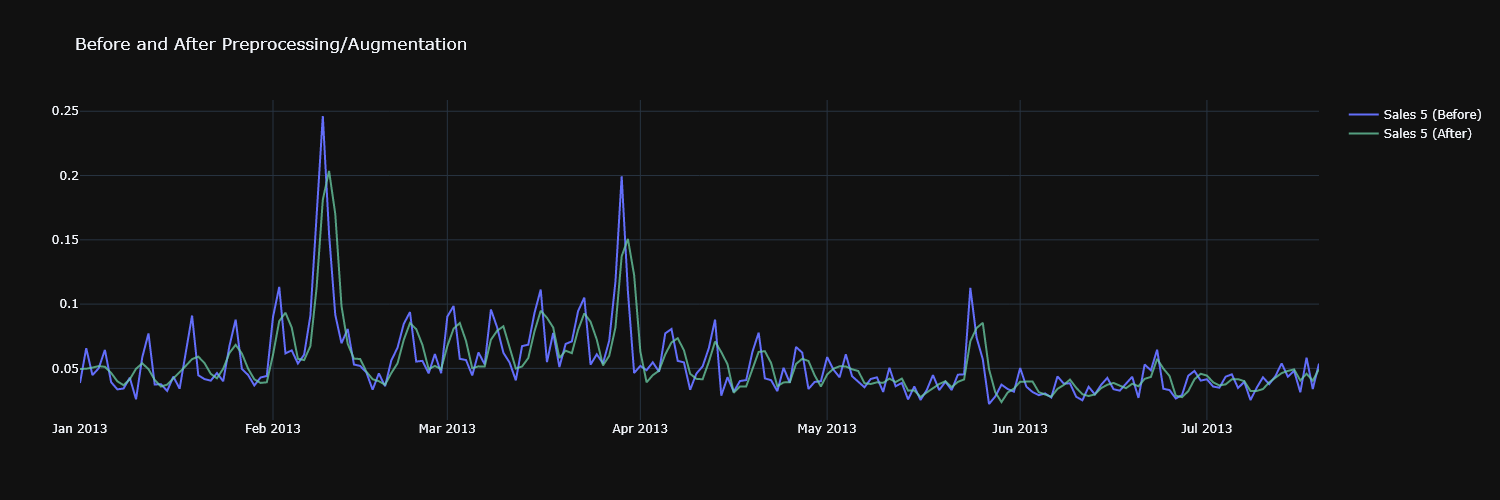

In [30]:
import plotly.graph_objects as go

fig = go.Figure()

# Show only some columns
cols = ['sales_5']

for col in cols:
    if col != 'date':
        col_name = col.replace('_', ' ').title()

        # Before preprocessing/segmentation
        fig.add_trace(
            go.Scatter(
                x = x_train['date'][:200],
                y = x_train[col][:200],
                name = f'{col_name} (Before)'
            )
        )

        # After preprocessing/segmentation
        fig.add_trace(
            go.Scatter(
                x = temp['date'][:200],
                y = temp[col][:200],
                name = f'{col_name} (After)',
                # Reduce line opaque
                line= {'color': 'rgba(107, 207, 166, 0.75)'}
            )
        )

fig.update_layout(title = 'Before and After Preprocessing/Augmentation')
fig.show(width = 1500)

### Train Model

In [703]:
from tensorflow import keras

discrete_layer = ScaledDiscretization(num_bins = 100)
discrete_layer.adapt(train_data[x_col])

model = keras.models.Sequential([
    keras.layers.Input(shape = (days_past, len(x_col))),

    # Pooling and upsampling need to be used together (when active)
    # Using same seed will ensure the same behavior for both layers
    # X means X% chance, when the random range is between 0 - X
    RandomApply(
        # If there are X days, min pool with size Y will output X/Y days
        TrainingOnly(keras.layers.AveragePooling1D(pool_size = 3, padding = 'same')),
        rate = 0.4, seed = 1234, name = 'avg_pooling_1'
    ),
    RandomApply(
        # If there are X days, upsampling with size Y will output X*Y days
        TrainingOnly(ImprovedUpSampling1D(size = 3, interpolation = 'bicubic')),
        rate = 0.4, seed = 1234, name = 'up_sampling_1'
    ),

    # # Randomly activate scaled discretization when previous layers are not active
    # # -X means X% chance, but when the random range is between (1-X) - 1
    # RandomApply(
    #     keras.layers.TimeDistributed(TrainingOnly(discrete_layer)),
    #     rate = -0.2, seed = 1234, name = 'discretization_1'
    # ),

    # --------------------

    keras.layers.LSTM(units = 256, return_sequences = True, name = 'lstm_1'),
    keras.layers.LSTM(units = 128, return_sequences = True, name = 'lstm_2'),
    keras.layers.LSTM(units = 256, return_sequences = True, name = 'lstm_3'),

    keras.layers.TimeDistributed(keras.layers.Dense(units = 128), name = 'dense_1'),
    keras.layers.PReLU(name = 'prelu_1'),
    keras.layers.Dropout(rate = 0.1, name = 'dropout_1'),

    keras.layers.TimeDistributed(keras.layers.Dense(units = 64), name = 'dense_2'),
    keras.layers.PReLU(name = 'prelu_2'),
    keras.layers.Dropout(rate = 0.1, name = 'dropout_2'),

    keras.layers.TimeDistributed(keras.layers.Dense(units = len(y_col)), name = 'dense_3')
], name = 'store_sales_lstm')

lr = 0.005
# Save to variable so it can be reset when needed
optimizer = keras.optimizers.Adam(learning_rate = lr)

model.compile(
    loss = keras.losses.Huber(),
    optimizer = optimizer,
    metrics = [ keras.metrics.MeanAbsoluteError(name = 'mae') ]
)

model.summary()

Model: "store_sales_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 avg_pooling_1 (RandomApply)  (None, 10, 133)          0         
                                                                 
 up_sampling_1 (RandomApply)  (None, 30, 133)          0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 256)           399360    
                                                                 
 lstm_2 (LSTM)               (None, 30, 128)           197120    
                                                                 
 lstm_3 (LSTM)               (None, 30, 256)           394240    
                                                                 
 dense_1 (TimeDistributed)   (None, 30, 128)           32896     
                                                                 
 prelu_1 (PReLU)             (None, 30, 128)      

In [704]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_mae',
    patience = 200,
    min_delta = 0.0001,
    mode = 'min',
    restore_best_weights = True,
    verbose = 1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5,
    patience = 50,
    mode = 'min',
    verbose = 1
)

class CheckMae(keras.callbacks.Callback):
    def __init__(self, threshold: int):
        super(CheckMae, self).__init__()
        self.threshold = threshold
        # Save best MAEs for current store
        self.best_mae = float('inf')
        self.best_val_mae = float('inf')

    def on_epoch_end(self, epoch, logs: dict): 
        mae = logs.get('mae')
        val_mae = logs.get('val_mae')

        if val_mae < self.best_val_mae:
            # Make sure both MAEs are from the same epoch
            self.best_val_mae = val_mae
            self.best_mae = mae

        if mae < self.threshold and val_mae < self.threshold:
            print(f'Epoch {epoch + 1}: Reached {mae} mae and {val_mae} val_mae, stopping training')
            self.model.stop_training = True

    def get_best_mae(self):
        return self.best_mae
    
    def get_best_val_mae(self):
        return self.best_val_mae

Don't execute this cell below to avoid re-training and losing output if the training has been done. **Note:** Limited to 10 stores for now due to very long training time.

In [705]:
# Prevent memory leak on repeated execution
keras.backend.clear_session()

# List of rows containing distinct store (start from the oldest store)
stores = store_from_oldest
# List of stores that are trained
store_trained = []
# Model training history
hist = {}
mae = {}

# TODO: Investigate model fit practice case in a loop
for i, store_nbr in enumerate(stores[:10]):
    temp = test_data[test_data['store_nbr'] == store_nbr]
    x_test, y_test = windowed_data(temp, x_col, y_col, days_past, days_future)

    temp = train_data[train_data['store_nbr'] == store_nbr]
    x_train, y_train = windowed_data(temp, x_col, y_col, days_past, days_future)

    # --------------------

    # https://stackoverflow.com/questions/24571005/return-max-value-from-pandas-dataframe-as-a-whole
    max_val = temp[matched_columns(dfpd.columns, [r'sales_[\w]*'])].max().max()
    min_val = temp[matched_columns(dfpd.columns, [r'sales_[\w]*'])].min().min()

    # Torelable MAE is 10-20% of data range, but aim for lower when possible
    torelable_mae = (max_val - min_val) * 10 / 100
    target_mae = (max_val - min_val) * 5 / 100
    check_mae = CheckMae(target_mae)

    # --------------------

    print(f'\n* Training for store {store_nbr} ({i + 1}/{stores.shape[0]}) (torelable MAE: {torelable_mae})')
    print(f'* Train data: {x_train.shape[0]} rows, test data: {x_test.shape[0]} rows')
    if x_train.shape[0] == 0:
        print(f'* Skipping store {store_nbr} (too new, not enough data)!')
        continue
    elif x_test.shape[0] == 0:
        print(f'* Aborting training (window size too big)!')
        break
    else: store_trained.append(store_nbr)

    # Reset learning rate on each loop, please use small value only
    # Large value will make the model too general (e.g. outputing straight line)
    lr_tolerance = 0.001
    if optimizer.learning_rate.numpy() < lr_tolerance:
        optimizer.learning_rate.assign(lr_tolerance)

    history = model.fit(
        x_train,
        y_train,
        epochs = 800,
        # 10 batched predictions per batch size
        batch_size = x_train.shape[0] // 10,
        validation_data = (x_test, y_test),
        callbacks = [ reduce_lr, check_mae, early_stopping ],
        shuffle = False,
        verbose = 1
    )

    hist[store_nbr] = history.history
    mae[store_nbr] = {
        'tmae': torelable_mae,
        'mae': check_mae.get_best_mae(),
        'vmae': check_mae.get_best_val_mae()
    }

model.save('misc/model.tf')


* Training for store 25 (1/54) (torelable MAE: 0.08118045476536043)
* Train data: 1267 rows, test data: 233 rows
Epoch 1/800
11/11 [==============================] - 5s 142ms/step - loss: 0.0150 - mae: 0.1201 - val_loss: 0.0257 - val_mae: 0.0886 - lr: 0.0050
Epoch 2/800
11/11 [==============================] - 0s 41ms/step - loss: 0.0025 - mae: 0.0527 - val_loss: 0.0233 - val_mae: 0.0752 - lr: 0.0050
Epoch 3/800
11/11 [==============================] - 0s 40ms/step - loss: 0.0015 - mae: 0.0399 - val_loss: 0.0235 - val_mae: 0.0629 - lr: 0.0050
Epoch 4/800
11/11 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0335 - val_loss: 0.0235 - val_mae: 0.0607 - lr: 0.0050
Epoch 5/800
11/11 [==============================] - 0s 34ms/step - loss: 9.0942e-04 - mae: 0.0303 - val_loss: 0.0235 - val_mae: 0.0590 - lr: 0.0050
Epoch 6/800
11/11 [==============================] - 0s 35ms/step - loss: 8.2120e-04 - mae: 0.0282 - val_loss: 0.0232 - val_mae: 0.0580 - lr: 0.0050
Epoch 7

INFO:tensorflow:Assets written to: misc/model.tf\assets


INFO:tensorflow:Assets written to: misc/model.tf\assets


In [31]:
skip_train = True

In [32]:
import json

# Numpy objects can't be encoded to json directly
# They need to be converted to native Python format first
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray): return obj.tolist()
        elif isinstance(obj, np.float32): return float(obj)
        elif isinstance(obj, np.int32): return int(obj)
        return super().default(self, obj)

def dict_key_to_str(obj: dict):
    return { str(k): v for k, v in obj.items() }

# --------------------

if not skip_train:
    with open('misc/store_trained.txt', 'w') as f:
        f.write(' '.join([ str(i) for i in store_trained ]))

    with open('misc/hist.json', 'w') as f:
        json.dump(dict_key_to_str(hist), f, indent = 4, cls = NumpyEncoder)

    with open('misc/mae.json', 'w') as f:
        json.dump(dict_key_to_str(mae), f, indent = 4, cls = NumpyEncoder)

In [33]:
def dict_key_to_int(obj: dict):
    return { int(k): v for k, v in obj.items() }

# BUG: "in_train_phase" is broken in certain TensorFlow release
# As workaround, I will replace it with layer that does nothing
class TrainingOnly(keras.layers.Layer):
    def __init__(self, layer = None, **kwargs):
        super().__init__(**kwargs)
 
    def call(self, inputs):
        return inputs
 
    def compute_output_shape(self, input_shape):
        return input_shape

if skip_train:
    with open(f'misc/hist.json') as f:
        hist = json.load(f)
        hist = dict_key_to_int(hist)

    with open(f'misc/mae.json') as f:
        mae = json.load(f)
        mae = dict_key_to_int(mae)

    with open(f'misc/store_trained.txt') as f:
        store_trained = f.read()
        store_trained = [ int(i) for i in store_trained.split() ]

    model = keras.models.load_model(
        f'misc/model.tf',
        custom_objects = {
            'RandomApply': RandomApply,
            'IterativeSwitch': IterativeSwitch,
            'TrainingOnly': TrainingOnly,
            'ScaledDiscretization': ScaledDiscretization,
            'ImprovedUpSampling1D': ImprovedUpSampling1D,
            'MinPooling1D': MinPooling1D
        }
    )

    # model.summary()

In [34]:
temp = (
    train_data[train_data['store_nbr'].isin(store_trained)],
    test_data[test_data['store_nbr'].isin(store_trained)]
)

df_mae = pd.DataFrame.from_dict(
    mae, orient = 'index'
).rename_axis('store_nbr')

df_hist = pd.DataFrame.from_dict(
    hist, orient = 'index'
).rename_axis('store_nbr')

print(f'Stores that are trained (length: {len(store_trained)}): {store_trained}')
print(f'Total rows used: {len(temp[0])} rows (train), {len(temp[1])} rows (test)')

display(df_hist.head())
display(df_mae.head())

Stores that are trained (length: 10): [25, 30, 31, 32, 33, 34, 35, 37, 38, 40]
Total rows used: 13390 rows (train), 3316 rows (test)


loss  \
store_nbr                                                      
25         [0.014996320009231567, 0.0025429900269955397, ...   
30                                   [0.0001944401883520186]   
31                                  [0.00048059894470497966]   
32                                   [0.0005344270030036569]   
33                                   [0.0003423283342272043]   

                                                         mae  \
store_nbr                                                      
25         [0.12009032815694809, 0.052674900740385056, 0....   
30                                    [0.012874270789325237]   
31                                    [0.019792350009083748]   
32                                     [0.02282782644033432]   
33                                     [0.01767674647271633]   

                                                    val_loss  \
store_nbr                                                      
25         [0.025692801922559738, 0.023312360048294067, 0...   
30                                  [0.00017942729755304754]   
31                                   [0.0005930178449489176]   
32                                  [0.00024545154883526266]   
33                                   [0.0005134109524078667]   

                                                     val_mae  \
store_nbr                                                      
25         [0.08856217563152313, 0.07519660145044327, 0.0...   
30                                     [0.01074318028986454]   
31                                    [0.019399872049689293]   
32                                     [0.01258879154920578]   
33                                    [0.014345332980155945]   

                                                          lr  
store_nbr                                                     
25         [0.004999999888241291, 0.004999999888241291, 0...  
30                                   [0.0010000000474974513]  
31                                   [0.0010000000474974513]  
32                                   [0.0010000000474974513]  
33                                   [0.0010000000474974513]

tmae       mae      vmae
store_nbr                              
25         0.081180  0.013777  0.055498
30         0.057582  0.012874  0.010743
31         0.059139  0.019792  0.019400
32         0.057377  0.022828  0.012589
33         0.059433  0.017677  0.014345

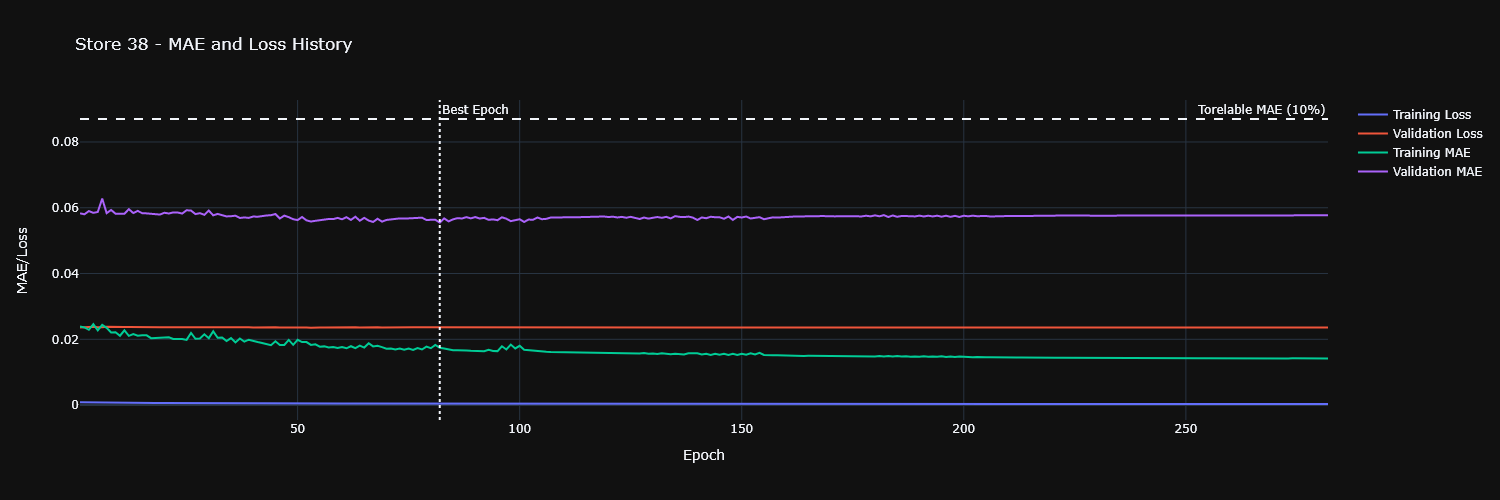

In [35]:
import plotly.graph_objects as go

fig = go.Figure()

# Change the store number if needed
store_nbr = 38
store = df_hist.loc[store_nbr]

fig.add_trace(
    go.Scatter(
        x = [ i + 1 for i in range(len(store['loss'])) ],
        y = store['loss'],
        name = 'Training Loss'
    )
)

fig.add_trace(
    go.Scatter(
        x = [ i + 1 for i in range(len(store['val_loss'])) ],
        y = store['val_loss'],
        name = 'Validation Loss'
    )
)

fig.add_trace(
    go.Scatter(
        x = [ i + 1 for i in range(len(store['mae'])) ],
        y = store['mae'],
        name = 'Training MAE'
    )
)

fig.add_trace(
    go.Scatter(
        x = [ i + 1 for i in range(len(store['val_mae'])) ],
        y = store['val_mae'],
        name = 'Validation MAE'
    )
)

fig.add_hline(
    y = df_mae.loc[store_nbr]['tmae'],
    line_dash = 'dash',
    annotation_text = 'Torelable MAE (10%)'
)

# Assume the lowest validation MAE as best epoch
fig.add_vline(
    x = store['val_mae'].index(df_mae.loc[store_nbr]['vmae']) + 1,
    line_dash = 'dot',
    annotation_text = 'Best Epoch'
)

fig.update_layout(
    # https://plotly.com/python/reference/layout/
    title = { 'text': f'Store {store_nbr} - MAE and Loss History' },
    # https://plotly.com/python/reference/layout/xaxis/
    xaxis = { 'title': 'Epoch' },
    # https://plotly.com/python/reference/layout/yaxis/
    yaxis = { 'title': 'MAE/Loss' },
    hovermode = 'x unified',
    hoverlabel = { 'namelength': -1 }
)

fig.show(width = 1500)

If training/validation MAE is below the torelable MAE line (10% of data range), it means the model prediction is very good for that store (theorically). However, the result still need to be checked in case the model is "cheating" (e.g. predicting straight line).

**Note:** The torelable MAE shown above is specific for each store, and based on train data range only. For global torelable MAE, which can be based on both train and test data range, see the cell below.

In [36]:
stores = store_from_oldest

def get_global_tol_mae(df: pd.DataFrame):
    max_val = df[matched_columns(df.columns, [r'sales_[\w]*'])].max().max()
    min_val = df[matched_columns(df.columns, [r'sales_[\w]*'])].min().min()
    torelable_mae = (max_val - min_val) * 10 / 100
    return torelable_mae

# MinMaxScaler is fitted using train data only, while test data is only transformed
# So I think it's kind of expected if MAE on combined/test data can exceed range 0-1
# Sales (test data) may increase each year, but train data in this case is 1 year behind
temp = pd.concat([train_data, test_data])
print('Global torelable MAE (train data only):', get_global_tol_mae(train_data))
print('Global torelable MAE (train + test data):', get_global_tol_mae(temp), '\n')
torelable_mae = get_global_tol_mae(train_data)

for store in stores:
    try:
        # Specific store
        cur_mae = df_mae.loc[store]['vmae']
        if cur_mae <= torelable_mae: pass_global_mae = True
        if cur_mae <= df_mae.loc[store]['vmae']: pass_local_mae = True
        
        if pass_local_mae and pass_global_mae:
            print(f'++ Store {store} ({cur_mae}) pass local and global torelable MAE!')
        elif pass_local_mae:
            print(f'+- Store {store} ({cur_mae}) only pass local torelable MAE!')
        elif pass_global_mae:
            print(f'-+ Store {store} ({cur_mae}) only pass global torelable MAE!')
        else:
            print(f'-- Store {store} ({cur_mae}) didn\'t pass local and global torelable MAE!')
    except KeyError:
        print(f'** Store {store} is skipped (too new and/or not trained)!')

# All stores (average)
cur_mae = df_mae['vmae'].mean()
if cur_mae <= torelable_mae:
    print(f'\nAverage stores ({cur_mae}) pass global torelable MAE!')
else:
    print(f'\nAverage stores ({cur_mae}) didn\'t pass global torelable MAE!')

del temp

Global torelable MAE (train data only): 0.10000000000000002
Global torelable MAE (train + test data): 5.2 

++ Store 25 (0.05549774318933487) pass local and global torelable MAE!
++ Store 30 (0.01074318028986454) pass local and global torelable MAE!
++ Store 31 (0.019399872049689293) pass local and global torelable MAE!
++ Store 32 (0.01258879154920578) pass local and global torelable MAE!
++ Store 33 (0.014345332980155945) pass local and global torelable MAE!
++ Store 34 (0.019425036385655403) pass local and global torelable MAE!
++ Store 35 (0.014647506177425385) pass local and global torelable MAE!
++ Store 37 (0.051264725625514984) pass local and global torelable MAE!
++ Store 38 (0.055481355637311935) pass local and global torelable MAE!
++ Store 40 (0.016048001125454903) pass local and global torelable MAE!
** Store 28 is skipped (too new and/or not trained)!
** Store 41 is skipped (too new and/or not trained)!
** Store 44 is skipped (too new and/or not trained)!
** Store 45 is s

### Model Prediction Test

In [37]:
fit_cols = list(scaler.feature_names_in_)

print(f'Input columns (length: {len(fit_cols)}): {fit_cols}')
print(f'Prediction columns (length: {len(y_col)}): {y_col}')

Input columns (length: 133): ['sales_0', 'sales_1', 'sales_2', 'sales_3', 'sales_4', 'sales_5', 'sales_6', 'sales_7', 'sales_8', 'sales_9', 'sales_10', 'sales_11', 'sales_12', 'sales_13', 'sales_14', 'sales_15', 'sales_16', 'sales_17', 'sales_18', 'sales_19', 'sales_20', 'sales_21', 'sales_22', 'sales_23', 'sales_24', 'sales_25', 'sales_26', 'sales_27', 'sales_28', 'sales_29', 'sales_30', 'sales_31', 'sales_32', 'transactions', 'oil_price', 'holiday_id', 'year', 'month', 'day_of_month', 'day_of_week', 'store_nbr_1', 'store_nbr_2', 'store_nbr_3', 'store_nbr_4', 'store_nbr_5', 'store_nbr_6', 'store_nbr_7', 'store_nbr_8', 'store_nbr_9', 'store_nbr_10', 'store_nbr_11', 'store_nbr_12', 'store_nbr_13', 'store_nbr_14', 'store_nbr_15', 'store_nbr_16', 'store_nbr_17', 'store_nbr_18', 'store_nbr_19', 'store_nbr_20', 'store_nbr_21', 'store_nbr_22', 'store_nbr_23', 'store_nbr_24', 'store_nbr_25', 'store_nbr_26', 'store_nbr_27', 'store_nbr_28', 'store_nbr_29', 'store_nbr_30', 'store_nbr_31', 'store

In [38]:
# Train data must already been scaled
store = train_data[train_data['store_nbr'] == store_nbr]

# TODO: Make another function to create windowed data without Y
# To predict real future where Y is not available
x_store, y_store, _, y_date = windowed_data(
    store, x_col, y_col, days_past, days_future, keep_date = True
)

# Each batch consist of N-days past/future
print('Store number to test:', store_nbr)
print('Batch, days, columns')
print(x_store.shape)
print(y_store.shape)
# Dates of Y (for plotting)
print(y_date.shape)

Store number to test: 38
Batch, days, columns
(1284, 30, 133)
(1284, 30, 34)
(1284, 30)


We use 30 days past (X) and 30 days future (Y) as an example. Assume that the specified store first opened on January 1 (and constantly open after that), where January is 31 days and Februari is 28 days, then the formula should be:

- First batch: `x_store[0]` = January 1 - January 30; `y_store[0]` = January 31 - March 1
- Second batch: `x_store[1]` = January 2 - January 31; `y_store[0]` = February 1 - March 2
- Third batch: `x_store[2]` = January 3 - February 1; `y_store[0]` = February 2 - March 3
- ...
- And so on, where `x_store[n]` = first 30 days; `y_store[n]` = next 30 days (prediction)

Obviously this is oversimplified, since there will be days where the store may not open. However, since X and Y values are filled by slicing rows (not days), it will always be filled with values where the store was open (whether it's the next day or skipped to the next N-days/months).

In [39]:
# Reverse transform train data using original scaler
orig_data = scaler_inv_transform(train_data, ['date', 'store_nbr'])
# The original scaler is fitted for all columns on train data
# Now we need to fit it for Y (prediction) columns only
y_scaler = MinMaxScaler()
y_scaler.fit(orig_data[y_col])

def nested_inv_transform(y: np.ndarray):
    '''Inverse transform model prediction (batched Y columns)'''
    y_inverse = list()

    for batch in y:
        # Inverse transform each day in current batch
        # From 0-1 to original data range
        batch = y_scaler.inverse_transform(batch)
        y_inverse.append(batch)

    return np.array(y_inverse)

y_pred = model.predict(x_store)

41/41 [==============================] - 5s 9ms/step


In [40]:
y_pred = nested_inv_transform(y_pred)
y_store = nested_inv_transform(y_store)

# View prediction (first batch only)
# Each column is for different sales
# Each row is for different day
print(f'Sales prediction (next {days_future} days):')
print(y_pred[0])
print(f'Real sales (next {days_future} days):')
print(y_store[0])

Sales prediction (next 30 days):
[[3.79982448e+00 1.77970219e+00 3.13533831e+00 ... 1.06558247e+01
  9.24139977e+00 1.49365015e+03]
 [3.04648876e+00 2.26459169e+00 3.00094271e+00 ... 1.16705437e+01
  6.20008326e+00 1.39322522e+03]
 [3.65086174e+00 1.95915627e+00 3.17681527e+00 ... 9.96379471e+00
  4.43655872e+00 1.37839246e+03]
 ...
 [5.22099876e+00 6.72314644e-01 9.88999188e-01 ... 8.80414295e+00
  2.49978209e+00 1.30378479e+03]
 [5.13068295e+00 1.09294271e+00 1.12755513e+00 ... 1.12258711e+01
  5.13852930e+00 1.35838843e+03]
 [4.87886667e+00 1.02323496e+00 1.46360934e+00 ... 1.07200985e+01
  6.38989925e+00 1.45191394e+03]]
Real sales (next 30 days):
[[2.00000000e+00 0.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  1.36419992e+01 1.60700000e+03]
 [1.00000000e+01 0.00000000e+00 5.00000000e+00 ... 0.00000000e+00
  2.35039997e+01 2.41400000e+03]
 [7.00000000e+00 0.00000000e+00 7.00000000e+00 ... 0.00000000e+00
  3.56790009e+01 2.28100000e+03]
 ...
 [8.00000000e+00 0.00000000e+00 3.0000

Plot it to make it more human readable.

In [41]:
df_y_pred = batch_to_df(y_pred, y_col, y_date)
df_y_store = batch_to_df(y_store, y_col, y_date)

print('Sales prediction (next 3 days):')
display(df_y_pred.head(3))
print('Real sales (next 3 days):')
display(df_y_store.head(3))

Sales prediction (next 3 days):


sales_0   sales_1   sales_2      sales_3   sales_4     sales_5    sales_6  \
0  3.799824  1.779702  3.135338  2371.607666 -0.002007  456.467041  38.325245   
1  3.046489  2.264592  3.000943  2718.870605  0.004328  385.757416  32.514679   
2  3.650862  1.959156  3.176815  3294.170654  0.005717  379.426453  23.491505   

       sales_7     sales_8     sales_9  ...    sales_25  sales_26  sales_27  \
0  1684.764282  621.013245  253.672836  ...  300.126373  0.386630  2.635815   
1  1719.791992  489.079498  276.700195  ...  238.238922 -0.213903  2.021357   
2  1746.425293  494.270111  299.122437  ...  334.526733  0.186490  4.183290   

     sales_28   sales_29    sales_30   sales_31  sales_32  transactions  \
0  221.326096  77.886841  312.642365  10.655825  9.241400   1493.650146   
1  174.757706  54.448170  140.466537  11.670544  6.200083   1393.225220   
2  167.200500  40.935181  444.861450   9.963795  4.436559   1378.392456   

         date  
0  2013-02-01  
1  2013-02-02  
2  2013-02-03  

[3 rows x 35 columns]

Real sales (next 3 days):


sales_0  sales_1  sales_2  sales_3  sales_4     sales_5  sales_6  sales_7  \
0      2.0      0.0      1.0    691.0      0.0  396.609985      0.0   1045.0   
1     10.0      0.0      5.0   1186.0      0.0  608.132019      0.0   1645.0   
2      7.0      0.0      7.0    886.0      0.0  633.437012      0.0   1490.0   

   sales_8     sales_9  ...  sales_25  sales_26  sales_27    sales_28  \
0    480.0  203.912994  ...     253.0       0.0       0.0  120.517006   
1    586.0  251.210999  ...     545.0       0.0       0.0  140.524002   
2    500.0  220.733994  ...     483.0       0.0       0.0  128.585007   

     sales_29  sales_30  sales_31   sales_32  transactions        date  
0  165.052002       0.0       0.0  13.641999        1607.0  2013-02-01  
1  226.955002       0.0       0.0  23.504000        2414.0  2013-02-02  
2  225.832001       0.0       0.0  35.679001        2281.0  2013-02-03  

[3 rows x 35 columns]

Note that this is only 1 store, so it has different pattern than previous EDA.


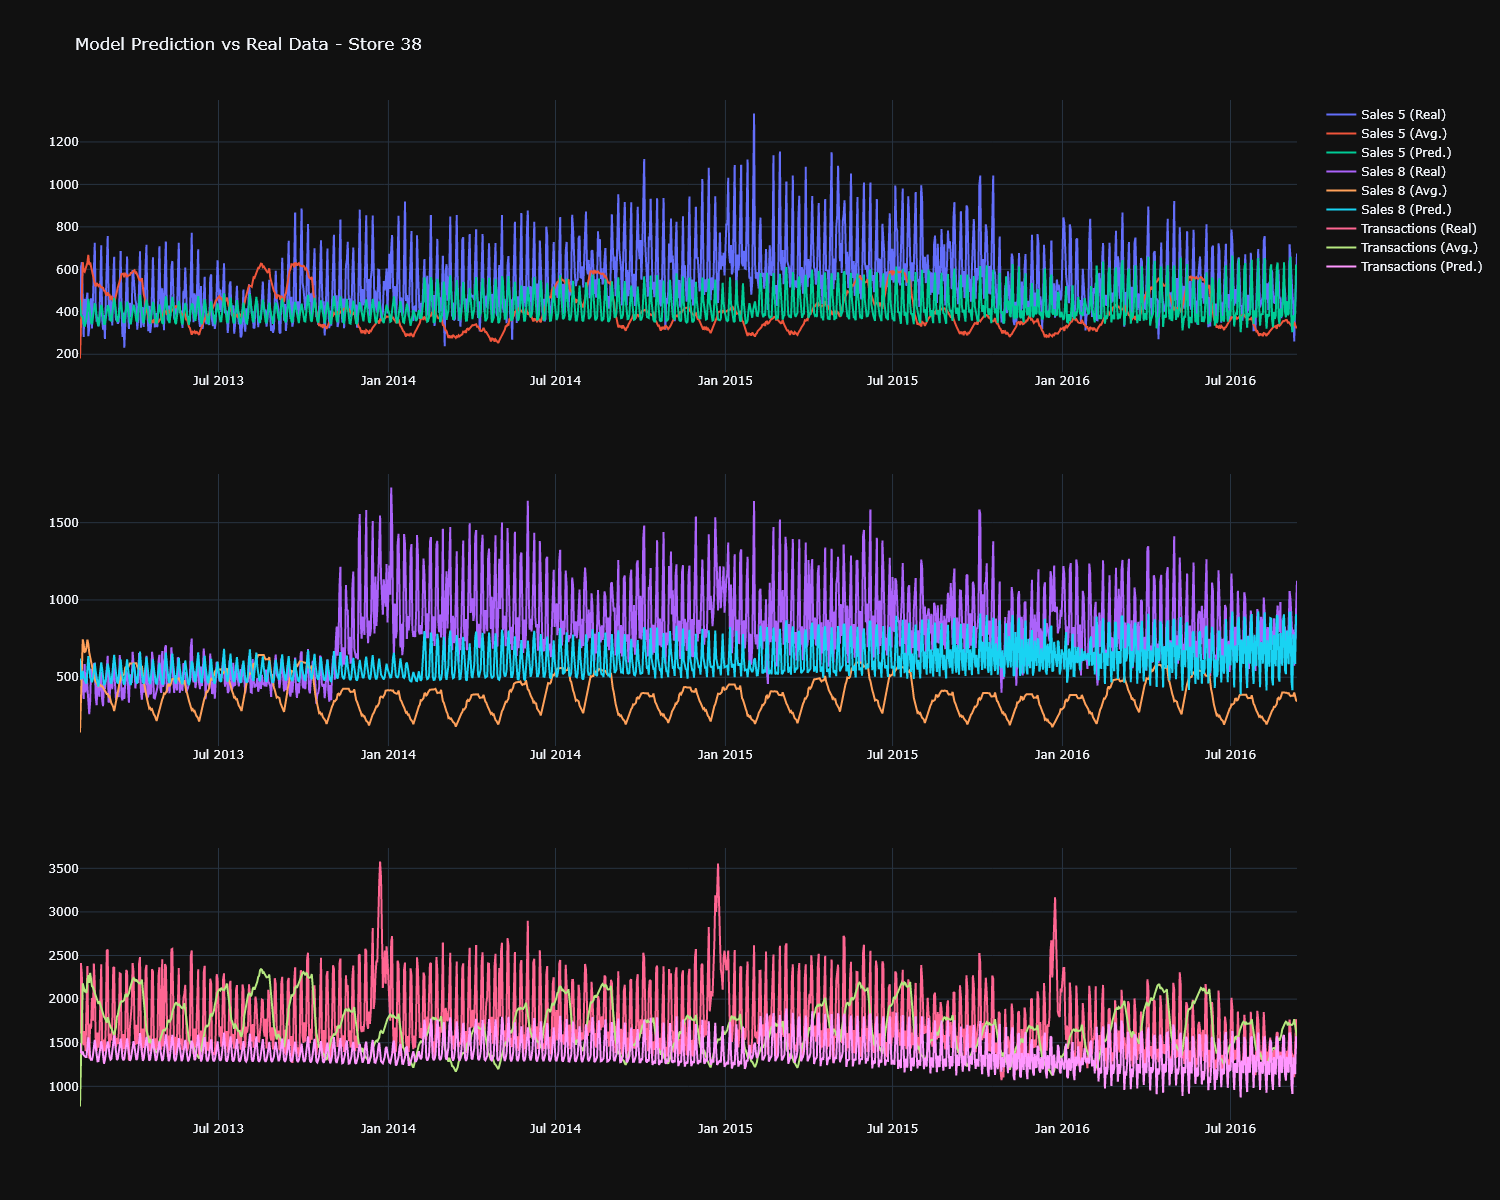

In [42]:
from plotly.subplots import make_subplots

fig = go.Figure()

# Show only some columns
cols = ['sales_5', 'sales_8', 'transactions']
fig = make_subplots(rows = len(cols), cols = 1)

for i, col in enumerate(cols):
    if col != 'date':
        col_name = col.replace('_', ' ').title()

        fig.add_trace(
            go.Scatter(
                x = df_y_store['date'],
                y = df_y_store[col],
                name = f'{col_name} (Real)'
            ), row = i + 1, col = 1
        )

        # Simple moving average
        temp = dfpd[col].rolling(
            window = days_past, min_periods = 0
        ).mean()

        fig.add_trace(
            go.Scatter(
                x = df_y_store['date'],
                y = temp,
                name = f'{col_name} (Avg.)'
            ), row = i + 1, col = 1
        )

        fig.add_trace(
            go.Scatter(
                x = df_y_pred['date'],
                y = df_y_pred[col],
                name = f'{col_name} (Pred.)'
            ), row = i + 1, col = 1
        )

print('Note that this is only 1 store, so it has different pattern than previous EDA.')

fig.update_layout(
    title = f'Model Prediction vs Real Data - Store {store_nbr}',
    template = 'plotly_dark'
)
fig.show(width = 1500, height = len(cols) * 400)

As you can see from the graph above, the LSTM model is able too predict most days correctly, although still slightly underfit and can't predict holiday spikes. It seems to be caused by these things:
- Features too complex (133 in, 34 out), need to be reduced or just use simpler algorithm (not LSTM)
- Sales and transactions are unpredictable by nature, and the model is just trying it's best effort
- The model trained using multiple `fit` may produce generalized model (not designed for specific store), or will only accurately predict the last trained store
- The flaw that there are missing dates and each store may not open at all times, so there may be skipped days causing "desync" on prediction
- Need to be trained on more epochs (hundreds/thousand, per this [reference](https://stackoverflow.com/questions/73457069/why-does-my-lstm-model-predict-wrong-values-although-the-loss-is-decreasing))

Observation:
- Less layers/filters can do better on single store, but once it goes through multiple stores the result will be much worse. This config combined with dropout/normalization layer will usually result straight line prediction
- Gaussian noise with extreme std (e.g. 0.5) can stimulate the model to be able to predict holiday spikes, but still need to be used with caution (since it can also mess with normal days). Theorically, sampling and discretization can also result the same effect, but after trying it the model still doesn't improve much
- Adding missing dates (by using Pandas interpolation) does not really improve accuracy/error rate, but every stores will now have similar MAE during training. Also, when using nearest/linear interpolation, big date gaps can be seen filled with relatively straight lines (when viewed using Plotly), this will definitely affect model training

## Misc
Issues and discussions that are still related to "time series for multiple places". Some (if not all) are unresolved/ambiguous, the most useful ones are already written above.

- https://datascience.stackexchange.com/questions/67171/can-i-use-lstm-models-to-evaluate-multiple-independent-time-series
- https://stackoverflow.com/questions/63025756/i-have-around-2000-data-points-for-multiple-locations-for-time-series-forecastin
- https://datascience.stackexchange.com/questions/45882/lstm-time-series-prediction-for-multiple-multivariate-series
- https://stats.stackexchange.com/questions/305863/how-to-train-lstm-model-on-multiple-time-series-data
- https://datascience.stackexchange.com/questions/67183/predicting-parallel-time-series-with-multiple-features
- https://stackoverflow.com/questions/59301113/using-timeseriesgenerator-with-a-multivariate-dataset-in-keras-tensorflow
- https://datascience.stackexchange.com/questions/117009/how-to-arrange-multiple-multivariate-time-series-of-different-length-before-pass
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator (deprecated)
- https://www.tensorflow.org/tutorials/structured_data/time_series
- https://keras.io/api/data_loading/timeseries/

Changelog:
- v1: 2x LSTM (64), 2x batch normalization, 2x dense. Result: same prediction pattern for different features
- v2: 2x LSTM (64), 2x batch normalization, 2x dropout (0.2 rate), 1x dense (time distributed), disabled shuffle. Result: same prediction pattern for different features, better accuracy but prediction is mostly straight lines (no longer zig-zag)
- v3: Same as above, added `store_nbr`, `year`, and `month` to prediction output. Result: still the same, but MAE is somewhat better
- v4: Removed `store_nbr`, `year`, and `month` again. Increase epoch to 500 (from 50) and early stop to 25 (from 10). Add bidirectional on first LSTM layer. Based on this [reference](https://stackoverflow.com/questions/73457069/why-does-my-lstm-model-predict-wrong-values-although-the-loss-is-decreasing)
- v5: 3x LSTM (50), 3x dropout, 1x dense. No bidirectional LSTM and change early stop to 50. Result: prediction now can produce different patterns for multiple features, but still overestimate (probably due to dropout?). 187 minutes training time (10 stores only)
- v6: Changed dropout to batch normalization. Added reduce LR (0.5 factor, 15 patience), increase LR from 0.001 to 0.005 (since MAE improved slower when using batch normalization), changed early stop from 50 to 30, and reduced max epoch from 500 to 200. Slightly worse result
- v7: Added 1x dropout (0.2 rate) before the last dense layer. Slightly worse result
- v8: Changed dropout to gaussian dropout (0.4 rate), added L1-L2 normalization to each LSTM layer. Reduce LR 6 patience, early stop 24 epoch. Result: MAE seems to be the same but more consistent (less gamble) than regular dropout, but the prediction is just straight lines.
- v9: Removed all regularizer and normalization on the model/layer, and changed gaussian dropout to gaussian noise (0.5 std) instead (after input layer). Use mini-batch with 800 epoch, 512 batch, 50 reduce lr, and 200 patience. Much better result, but still can't reach spike on some days like Christmas (only generalized zig-zag)
- v10: Using 360 days with 0.5 train-test split. 4 LSTM layers (64), same gaussian layer and mini-batch. Prediction is just straight line.
- v11: Switch batck to 30 days with 0.8 train size, 2 LSTM layers (256, 128), same gaussian layer, 128 mini-batch. Better graph, zig-zag pattern and seasonal pattern, but still wrong and can't follow holiday sales spike
- v12: Same as above but added extra LSTM layer (256) at the end. Same behavior, but the zig-zag range (max-min) is more extreme than previous model
- **v13 (last used)**: Reduced last LSTM layer from 256 to 64. Prediction is better but for single store only, same zig-zag pattern as previous model, but able to extract holiday spike (though the range is not as extreme as the real spike, about 60-80% of original range)
- v14: Removed gaussian noise, added dropout (0.4 rate) as the last layer (before dense). Result: worse prediction, holiday spike not detected, pattern is overestimating on normal days most of the times (probably to mitigate holiday spike?)
- v15-v19: Added many "hacked" layers, since some of the built-in layers are pretty much useless (e.g. UpSampling1D, Discretization). No written changes since there are too many experimentations
- **v20 (currently used)**: Used random pooling and sampling (bicubic) with hacky implementation. Multi layer LSTM and dense based on this [reference](https://www.kaggle.com/code/shixw125/1st-place-nn-model-public-0-507-private-0-513)

Todo:
- ~~Add missing dates before interpolating/filling null values~~ (disabled, doesn't make prediction better)
- Implement a better smoothing algorithm (e.g. LTTB, ~~discretization, bicubic interpolation~~) or just ditch LSTM
- ~~Visualize the result before and after smoothing, or even visualize each layer of the model~~
- Predict sales for each item id rather than family. Since each family is composed of multiple item ids, we can use each item sales ratio (from a specific day) to predict future sales (e.g. next year on the same day)